# Part 2
## (a) What are the best times and days of the week to minimize delays each year?

## 2.1 Data Cleaning

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import chardet
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from statsmodels.tools.tools import add_constant
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, auc

Creating a list of CSV datas from 1998 till 2007. We run strip() and apply it on the resulting data frame to remove leading and trailing white spaces if data type is "object". This will ensure the merging operation later is accurate.

In [19]:
files = []
for year in range(1998, 2008):
    with open(f"{year}.csv", 'rb') as f:
        result = chardet.detect(f.read()) #Using chardet libraries to check the encoding of each files.
        encoding = result['encoding']
        files.append(pd.read_csv(f"{year}.csv", encoding=encoding, low_memory = False))

#join all data into a single DataFrame
df = pd.concat(files, ignore_index = True)
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

summary_df = df.describe()
print(summary_df)

               Year         Month    DayofMonth     DayOfWeek       DepTime  \
count  6.318833e+07  6.318833e+07  6.318833e+07  6.318833e+07  6.176004e+07   
mean   2.002832e+03  6.508264e+00  1.572424e+01  3.941007e+00  1.346440e+03   
std    2.870844e+00  3.425466e+00  8.784102e+00  1.990052e+00  4.787489e+02   
min    1.998000e+03  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
25%    2.000000e+03  4.000000e+00  8.000000e+00  2.000000e+00  9.320000e+02   
50%    2.003000e+03  7.000000e+00  1.600000e+01  4.000000e+00  1.332000e+03   
75%    2.005000e+03  9.000000e+00  2.300000e+01  6.000000e+00  1.737000e+03   
max    2.007000e+03  1.200000e+01  3.100000e+01  7.000000e+00  2.930000e+03   

         CRSDepTime       ArrTime    CRSArrTime     FlightNum  \
count  6.318833e+07  6.162525e+07  6.318833e+07  6.318833e+07   
mean   1.332994e+03  1.492251e+03  1.493440e+03  1.704719e+03   
std    4.757524e+02  5.037042e+02  4.950956e+02  1.647448e+03   
min    0.000000e+00  1.00000

Creating reusable functions for repetitive tasks.

In [20]:
# Day of week Factor
def day_factor(df, day_var):
    day_order = ["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"]
    df[day_var] = pd.Categorical(df[day_var], categories=range(1, 8), ordered=True)
    df[day_var] = df[day_var].cat.rename_categories(day_order)
    return df

In [21]:
# Month Factor
def month_factor(df, month_var):
    month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    df[month_var] = pd.Categorical(df[month_var], categories=range(1, 13), ordered=True)
    df[month_var] = df[month_var].cat.rename_categories(month_order)
    return df

In [22]:
# Covert column to Date and Time format
def convert_to_time_format(df, columns_to_convert):
    for col in columns_to_convert:
        df[col] = pd.to_datetime(df[col], format='%H%M').dt.time
    return df

In [23]:
def explore_distribution(data, columns):
    for col in columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(data=data, x=col)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.show()

In [24]:
def create_time_intervals(data, time_col):
    # Define break points for intervals
    time_intervals = list(range(0, 2500, 400))

    # Define names for intervals
    interval_names = ["12am - 4am", "4am - 8am", "8am - 12pm", "12pm - 4pm", "4pm - 8pm", "8pm - 12am"]

    # Creating a new column with time intervals
    data.loc[:, 'Bins'] = pd.cut(data[time_col], bins=time_intervals, labels=interval_names, right=False)

    return data

Transforming month and day of week data into easily understandable categories.

In [25]:
df = month_factor(df, 'Month')
df = day_factor(df, 'DayOfWeek')

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63188334 entries, 0 to 63188333
Data columns (total 29 columns):
 #   Column             Dtype   
---  ------             -----   
 0   Year               int64   
 1   Month              category
 2   DayofMonth         int64   
 3   DayOfWeek          category
 4   DepTime            float64 
 5   CRSDepTime         int64   
 6   ArrTime            float64 
 7   CRSArrTime         int64   
 8   UniqueCarrier      object  
 9   FlightNum          int64   
 10  TailNum            object  
 11  ActualElapsedTime  float64 
 12  CRSElapsedTime     float64 
 13  AirTime            float64 
 14  ArrDelay           float64 
 15  DepDelay           float64 
 16  Origin             object  
 17  Dest               object  
 18  Distance           int64   
 19  TaxiIn             int64   
 20  TaxiOut            int64   
 21  Cancelled          int64   
 22  CancellationCode   object  
 23  Diverted           int64   
 24  CarrierDelay       flo

In [26]:
# Check the number of rows before removing duplicates
print("Number of rows before removing duplicates:", len(df))

# Remove duplicates
df = df.drop_duplicates()

# Check the number of rows after removing duplicates
print("Number of rows after removing duplicates:", len(df))

Number of rows before removing duplicates: 63188334
Number of rows after removing duplicates: 63188261


Selecting the variables we may need to address question 2a.

In [27]:
# Select variables
flights_subset_1 = df[['Year', 'Month', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'DepDelay', 'ArrDelay', 'Diverted', 'Cancelled']]

# Display DataFrame information
print(flights_subset_1.info())

<class 'pandas.core.frame.DataFrame'>
Index: 63188261 entries, 0 to 63188333
Data columns (total 9 columns):
 #   Column      Dtype   
---  ------      -----   
 0   Year        int64   
 1   Month       category
 2   DayOfWeek   category
 3   DepTime     float64 
 4   CRSDepTime  int64   
 5   DepDelay    float64 
 6   ArrDelay    float64 
 7   Diverted    int64   
 8   Cancelled   int64   
dtypes: category(2), float64(3), int64(4)
memory usage: 3.9 GB
None


Check number of missing values for each variable. Missing value for DepTime, DepDelay and ArrDelay may be due to diverted or cancelled flights.

In [28]:
missing_summary = flights_subset_1.isna().sum().reset_index()
missing_summary.columns = ['variable', 'missing_count']
print(missing_summary)

     variable  missing_count
0        Year              0
1       Month              0
2   DayOfWeek              0
3     DepTime        1428276
4  CRSDepTime              0
5    DepDelay        1428276
6    ArrDelay        1563068
7    Diverted              0
8   Cancelled              0


Check if missing data is associated with diverted or cancelled flights.

In [29]:
# Creating a table that counts the number of diverted and non-diverted flights
diverted_counts = flights_subset_1['Diverted'].value_counts()
print(diverted_counts)

# Assessing if NAs are presented for diverted flights
print(flights_subset_1[flights_subset_1['Diverted'] == 1].head())

Diverted
0    63053470
1      134791
Name: count, dtype: int64
     Year Month DayOfWeek  DepTime  CRSDepTime  DepDelay  ArrDelay  Diverted  \
143  1998   Jan       Sat   1440.0        1435       5.0       NaN         1   
144  1998   Jan       Sun   1455.0        1435      20.0       NaN         1   
593  1998   Jan       Sun    745.0         745       0.0       NaN         1   
655  1998   Jan       Sun    859.0         905      -6.0       NaN         1   
686  1998   Jan       Sun    915.0         825      50.0       NaN         1   

     Cancelled  
143          0  
144          0  
593          0  
655          0  
686          0  


In [30]:
# Creating a table that counts the number of cancelled and non-cancelled flights
cancelled_counts = flights_subset_1['Cancelled'].value_counts()
print(cancelled_counts)

# Assessing if NAs are presented for cancelled flights
print(flights_subset_1[flights_subset_1['Cancelled'] == 1].head())

Cancelled
0    61759985
1     1428276
Name: count, dtype: int64
     Year Month DayOfWeek  DepTime  CRSDepTime  DepDelay  ArrDelay  Diverted  \
37   1998   Jan       Fri      NaN        1250       NaN       NaN         0   
268  1998   Jan       Mon      NaN        1510       NaN       NaN         0   
273  1998   Jan       Sat      NaN        1514       NaN       NaN         0   
283  1998   Jan       Tue      NaN        1514       NaN       NaN         0   
304  1998   Jan       Sat      NaN         710       NaN       NaN         0   

     Cancelled  
37           1  
268          1  
273          1  
283          1  
304          1  


We will exclude missing values from our analysis, focusing solely on flights that are not canceled or diverted, as we aim to determine the optimal time to minimize delays. After removing diverted and cancelled flights we still have 1 observation with missing value.

In [31]:
# Remove diverted and cancelled flights from our dataframe subset
flights_subset_1 = flights_subset_1[(flights_subset_1['Cancelled'] == 0) & (flights_subset_1['Diverted'] == 0)]

# Remove missing summary
missing_summary = flights_subset_1.isna().sum().reset_index()
missing_summary.columns = ['variable', 'missing_count']

print(missing_summary)


     variable  missing_count
0        Year              0
1       Month              0
2   DayOfWeek              0
3     DepTime              0
4  CRSDepTime              0
5    DepDelay              0
6    ArrDelay              1
7    Diverted              0
8   Cancelled              0


In [32]:
# Checking the observation with missing value
rows_with_missing = flights_subset_1[flights_subset_1['ArrDelay'].isna()]

print(rows_with_missing)

          Year Month DayOfWeek  DepTime  CRSDepTime  DepDelay  ArrDelay  \
29628557  2003   Apr       Sat    135.0        1945       0.0       NaN   

          Diverted  Cancelled  
29628557         0          0  


After examining the flights dataframe, we couldn't identify any reasons for the missing values, nor can we compute the actual values due to the absence of flight dates. Therefore, we'll proceed by excluding this data from our analysis.

In [33]:
missing_row_indices = rows_with_missing.index

rows_in_original_df = df.loc[missing_row_indices]

print(rows_in_original_df)

          Year Month  DayofMonth DayOfWeek  DepTime  CRSDepTime  ArrTime  \
29628557  2003   Apr           5       Sat    135.0        1945    439.0   

          CRSArrTime UniqueCarrier  FlightNum  ... TaxiIn  TaxiOut  Cancelled  \
29628557        2316            OO       3993  ...      5       13          0   

          CancellationCode  Diverted  CarrierDelay WeatherDelay NASDelay  \
29628557               NaN         0           NaN          NaN      NaN   

          SecurityDelay  LateAircraftDelay  
29628557            NaN                NaN  

[1 rows x 29 columns]


In [34]:
FlightNum_3993 = df[df['FlightNum'] == 3993]
print(FlightNum_3993.head())

          Year Month  DayofMonth DayOfWeek  DepTime  CRSDepTime  ArrTime  \
28021463  2003   Jan           1       Wed   1120.0        1120   1220.0   
28022462  2003   Jan           2      Thur   1123.0        1120   1250.0   
28023536  2003   Jan           3       Fri   1120.0        1120   1211.0   
28077473  2003   Jan           1       Wed   1653.0        1700   1749.0   
28077474  2003   Jan           2      Thur   1657.0        1700   1747.0   

          CRSArrTime UniqueCarrier  FlightNum  ... TaxiIn  TaxiOut  Cancelled  \
28021463        1215            OO       3993  ...     10       10          0   
28022462        1215            OO       3993  ...      3       51          0   
28023536        1215            OO       3993  ...      3       12          0   
28077473        1755            XE       3993  ...      9        8          0   
28077474        1755            XE       3993  ...      4        7          0   

          CancellationCode  Diverted  CarrierDelay Weath

We check again to ensure there are no missing values.

In [35]:
# Removing observations with missing values
flights_subset_1 = flights_subset_1.dropna(subset=['ArrDelay'])

# Checking if there are still any other missing values
missing_summary = flights_subset_1.isna().sum().reset_index()
missing_summary.columns = ['variable', 'missing_count']

print(missing_summary)

     variable  missing_count
0        Year              0
1       Month              0
2   DayOfWeek              0
3     DepTime              0
4  CRSDepTime              0
5    DepDelay              0
6    ArrDelay              0
7    Diverted              0
8   Cancelled              0


Removing variables to reduce memory usage and streamline data processing.


In [36]:
flights_subset_1 = flights_subset_1.drop(columns=['Diverted', 'Cancelled'])

We'll create a new variable called "Total Delay," which represents the average of departure and arrival delays. Considering our goal to minimize delays, it's crucial to take both departure and arrival delays into account.

In [37]:
flights_subset_1['Total Delay'] = (flights_subset_1['DepDelay'] + flights_subset_1['ArrDelay']) / 2

print(flights_subset_1.head())

   Year Month DayOfWeek  DepTime  CRSDepTime  DepDelay  ArrDelay  Total Delay
0  1998   Jan       Sat    715.0         715       0.0       0.0          0.0
1  1998   Jan       Sun    715.0         715       0.0     -10.0         -5.0
2  1998   Jan       Mon    715.0         715       0.0      -9.0         -4.5
3  1998   Jan       Tue    715.0         715       0.0      -4.0         -2.0
4  1998   Jan       Wed    715.0         715       0.0      -4.0         -2.0


Observe the distribution of each variable using histogram. It appears that there might be outliers for the "Total_Delay" variable, indicating a need for further investigation.

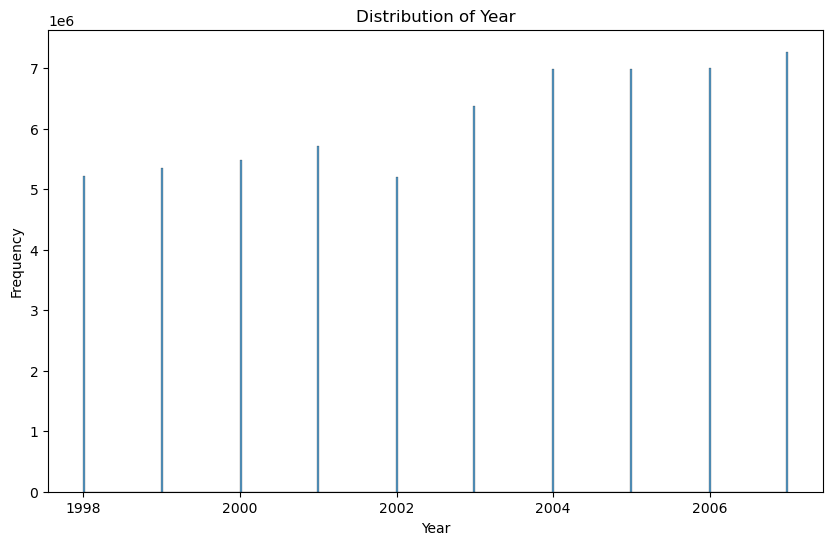

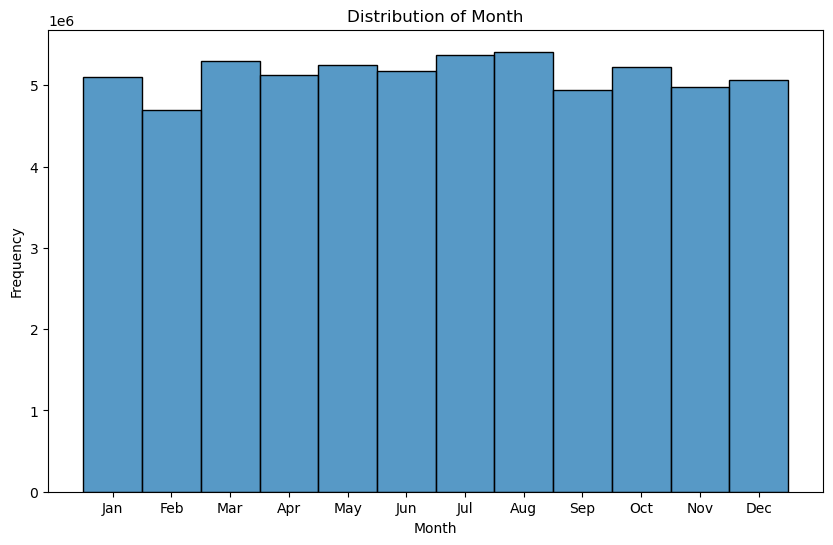

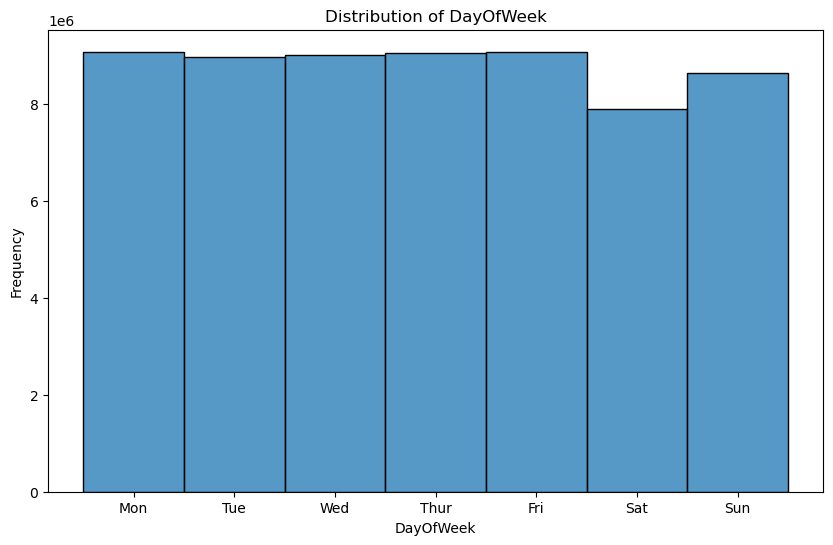

In [38]:
# Call the explore_distribution function
explore_distribution(flights_subset_1, ["Year", "Month", "DayOfWeek"])

We observe the distribution for Total Delay using Kernel Density Plot. It appears that there might be outliers for the "Total_Delay" variable, indicating a need for further investigation.

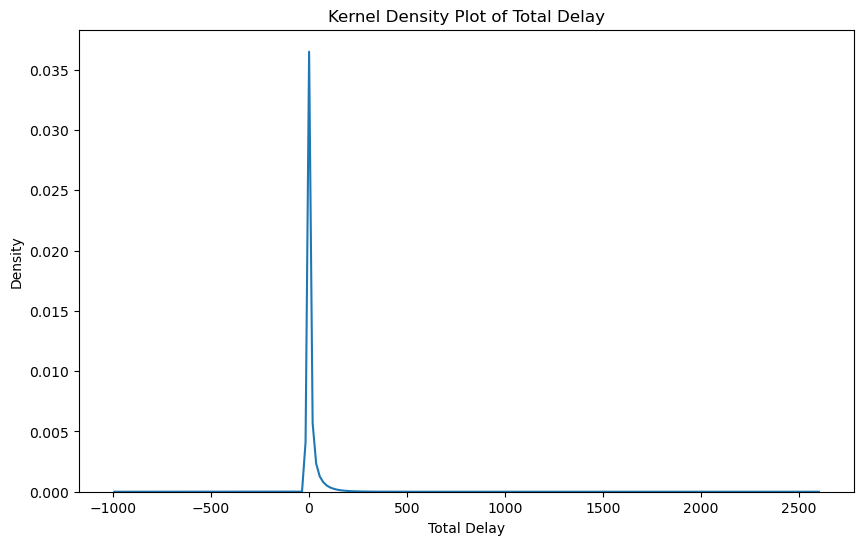

In [39]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=flights_subset_1['Total Delay'])
plt.title("Kernel Density Plot of Total Delay")
plt.xlabel("Total Delay")
plt.ylabel("Density")
plt.show()

To conduct further investigation into the outliers, we filter all flights with departure and arrival delays greater than 15 minutes, as these are considered delayed flights. Then, we plot a boxplot. The boxplot reveals several outliers with values exceeding 147.75 mins.

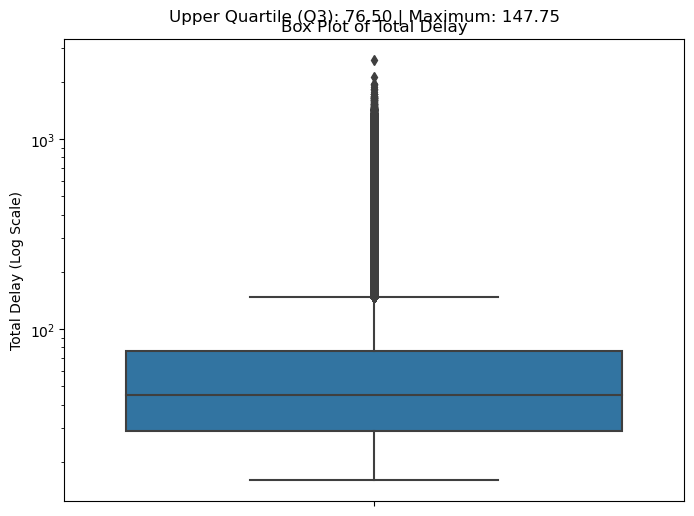

In [40]:
# Filtering delayed flights
flights_subset_1_filter_delayed_flights = flights_subset_1[
    (flights_subset_1['DepDelay'] > 15) & (flights_subset_1['ArrDelay'] > 15)
]

# Calculating IQR to determine outliers threshold
Q3 = flights_subset_1_filter_delayed_flights['Total Delay'].quantile(0.75)
IQR = flights_subset_1_filter_delayed_flights['Total Delay'].quantile(0.75) - flights_subset_1_filter_delayed_flights['Total Delay'].quantile(0.25)
maximum = Q3 + 1.5 * IQR

# Plotting the Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(y="Total Delay", data=flights_subset_1_filter_delayed_flights)
plt.yscale('log')
plt.title("Box Plot of Total Delay")
plt.ylabel("Total Delay (Log Scale)")
plt.suptitle(f"Upper Quartile (Q3): {Q3:.2f} | Maximum: {maximum:.2f}", y=0.93)
plt.show()


Given that 6.53% of the flights are outliers, which is a significant proportion, we will incorporate data with a total delay of less than 1440 minutes (equivalent to one day) for our analysis instead. Flights with delays exceeding 1440 minutes will be excluded, as excessively large delays can disproportionately influence the mean and potentially skew our analysis.

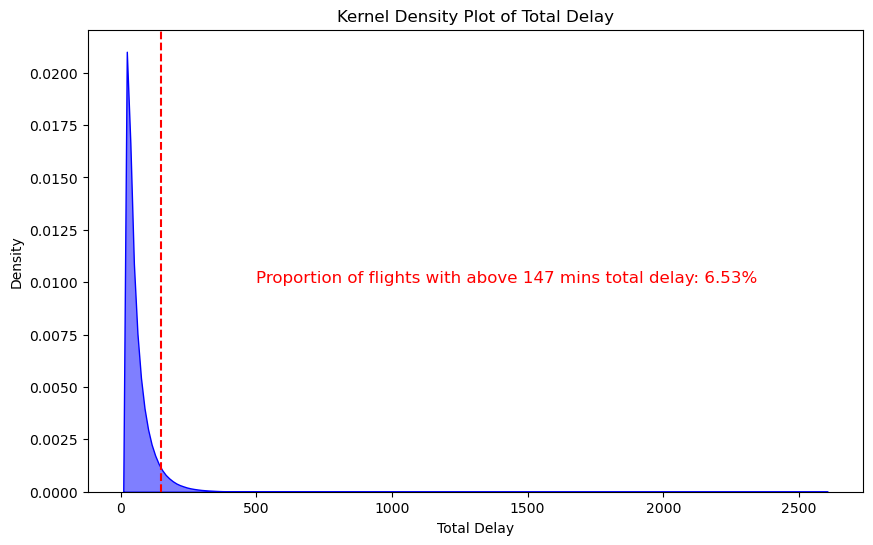

In [41]:
# Filter flights above 147 minutes Total Delay (Outlier Threshold)
proportion_above_147 = (flights_subset_1_filter_delayed_flights['Total Delay'] > 147).mean()

# Plotting Kernel density plot and calculating the proportion of outlier flights
plt.figure(figsize=(10, 6))
sns.kdeplot(data=flights_subset_1_filter_delayed_flights['Total Delay'], color="blue", fill=True, alpha=0.5)
plt.axvline(x=147, linestyle="dashed", color="red")
plt.text(500, 0.01, f"Proportion of flights with above 147 mins total delay: {proportion_above_147:.2%}", color="red", size=12)
plt.title("Kernel Density Plot of Total Delay")
plt.xlabel("Total Delay")
plt.ylabel("Density")
plt.show()

62 observations with Total Delays more than 1440mins are identified, contributing to 0.000007% of the data.

In [42]:
# Compute the proportion of flights with more than 1 day delay
proportion_above_depdelay_1440 = (flights_subset_1_filter_delayed_flights['DepDelay'] > 1440).mean()

# Filter flights that are more than one day
flights_above_1440 = flights_subset_1_filter_delayed_flights[flights_subset_1_filter_delayed_flights['DepDelay'] > 1440]

# Count the number of flights with more than one day delay
num_flights_above_depdelay_1440 = len(flights_above_1440)

# Print the proportion and number of flights with more than one day delay
print(proportion_above_depdelay_1440)
print(num_flights_above_depdelay_1440)

# Display summary statistics of flights with more than one day delay
print(flights_above_1440.describe())


7.1667791581277e-06
62
              Year      DepTime   CRSDepTime     DepDelay     ArrDelay  \
count    62.000000    62.000000    62.000000    62.000000    62.000000   
mean   2003.935484  1374.209677  1177.161290  1629.306452  1629.500000   
std       2.553499   532.521627   442.271306   194.614422   195.393739   
min    1998.000000    12.000000   600.000000  1444.000000  1428.000000   
25%    2002.000000   949.750000   820.000000  1497.000000  1491.000000   
50%    2005.000000  1420.000000  1175.000000  1591.500000  1599.500000   
75%    2006.000000  1751.000000  1526.500000  1686.000000  1682.750000   
max    2007.000000  2351.000000  2350.000000  2601.000000  2598.000000   

       Total Delay  
count    62.000000  
mean   1629.403226  
std     194.449704  
min    1436.000000  
25%    1492.875000  
50%    1592.250000  
75%    1678.125000  
max    2599.500000  


Omitting Total_Delay > 1440

In [43]:
flights_subset_1 = flights_subset_1[flights_subset_1['DepDelay'] < 1441]

We will convert the "CRSDepTime" variable into categorical time intervals of 4 hours each.


In [44]:
# Create time intervals for CRSDepTime and rename the resulting column using custom function.
flights_subset_1 = create_time_intervals(flights_subset_1, 'CRSDepTime')


In [45]:
flights_subset_1 = flights_subset_1.rename(columns={'Bins': 'DepartureBins'})

# Display the DataFrame with the new column
print(flights_subset_1.head())

   Year Month DayOfWeek  DepTime  CRSDepTime  DepDelay  ArrDelay  Total Delay  \
0  1998   Jan       Sat    715.0         715       0.0       0.0          0.0   
1  1998   Jan       Sun    715.0         715       0.0     -10.0         -5.0   
2  1998   Jan       Mon    715.0         715       0.0      -9.0         -4.5   
3  1998   Jan       Tue    715.0         715       0.0      -4.0         -2.0   
4  1998   Jan       Wed    715.0         715       0.0      -4.0         -2.0   

  DepartureBins  
0     4am - 8am  
1     4am - 8am  
2     4am - 8am  
3     4am - 8am  
4     4am - 8am  


We conduct ANOVA to compare the mean delay times across different time intervals, month and Day of week to compare the mean.

In [46]:
#Renaming Column
flights_subset_1 = flights_subset_1.rename(columns={'Total Delay': 'Total_Delay'})
model = ols('Total_Delay ~ DepartureBins', data=flights_subset_1).fit()
anova_time_interval = sm.stats.anova_lm(model)

print(anova_time_interval)

                       df        sum_sq       mean_sq              F  PR(>F)
DepartureBins         5.0  1.113013e+09  2.226027e+08  227245.812366     0.0
Residual       61625110.0  6.036597e+10  9.795678e+02            NaN     NaN


In [47]:
lm_model = sm.OLS.from_formula('Total_Delay ~ DepartureBins', data=flights_subset_1).fit()

# Obtain confidence intervals for group means
ci = lm_model.conf_int(alpha=0.05)
print(ci)

                                    0         1
Intercept                    6.060467  6.232400
DepartureBins[T.4am - 8am]  -4.958427 -4.781406
DepartureBins[T.8am - 12pm] -1.873582 -1.698936
DepartureBins[T.12pm - 4pm]  2.313496  2.488234
DepartureBins[T.4pm - 8pm]   6.947838  7.122651
DepartureBins[T.8pm - 12am]  5.955909  6.134894


In [48]:
model = ols('Total_Delay ~ DayOfWeek', data=flights_subset_1).fit()
anova_DayOfWeek = sm.stats.anova_lm(model)

print(anova_DayOfWeek)

                   df        sum_sq       mean_sq             F  PR(>F)
DayOfWeek         6.0  1.653052e+08  2.755087e+07  27690.792214     0.0
Residual   61625124.0  6.131373e+10  9.949470e+02           NaN     NaN


In [49]:
lm_model = sm.OLS.from_formula('Total_Delay ~ DayOfWeek', data=flights_subset_1).fit()

# Obtain confidence intervals for group means
ci = lm_model.conf_int(alpha=0.05)
print(ci)

                          0         1
Intercept          7.994697  8.035778
DayOfWeek[T.Tue]  -1.788624 -1.730363
DayOfWeek[T.Wed]  -0.688719 -0.630526
DayOfWeek[T.Thur]  1.573063  1.631197
DayOfWeek[T.Fri]   2.433465  2.491547
DayOfWeek[T.Sat]  -2.691462 -2.631234
DayOfWeek[T.Sun]   0.061112  0.119938


In [50]:
model = ols('Total_Delay ~ Month', data=flights_subset_1).fit()
anova_Month = sm.stats.anova_lm(model)

print(anova_Month)

                  df        sum_sq       mean_sq            F  PR(>F)
Month           11.0  2.917113e+08  2.651921e+07  26708.95534     0.0
Residual  61625119.0  6.118733e+10  9.928959e+02          NaN     NaN


In [51]:
lm_model = sm.OLS.from_formula('Total_Delay ~ Month', data=flights_subset_1).fit()

# Obtain confidence intervals for group means
ci = lm_model.conf_int(alpha=0.05)
print(ci)

                     0         1
Intercept     7.996313  8.051033
Month[T.Feb] -0.173589 -0.094596
Month[T.Mar] -0.399992 -0.323331
Month[T.Apr] -1.958795 -1.881522
Month[T.May] -1.377038 -1.300228
Month[T.Jun]  3.467511  3.544597
Month[T.Jul]  2.747001  2.823405
Month[T.Aug]  1.149008  1.225253
Month[T.Sep] -3.591100 -3.513092
Month[T.Oct] -2.300957 -2.224037
Month[T.Nov] -2.139214 -2.061397
Month[T.Dec]  2.745588  2.823080


# 2.3 DATA VISUALIZATION

### When is the best time to fly to minimize delay?

To create a summary of the proportion of delayed flights by different time intervals and day of the week, we'll calculate the percentage of delayed flights within each time interval and day of the week category. Based on the analysis, it appears that the time interval from 4 am to 8 am has the lowest proportion of delayed flights, suggesting it might be the best time to travel.

In [52]:
delayed_proportion_summary_by_interval = flights_subset_1.groupby(['DayOfWeek', 'DepartureBins']).apply(lambda x: np.mean((x['DepDelay'] > 15) & (x['ArrDelay'] > 15))).reset_index(name='DelayProp')

print(delayed_proportion_summary_by_interval)

   DayOfWeek DepartureBins  DelayProp
0        Mon    12am - 4am   0.123720
1        Mon     4am - 8am   0.055534
2        Mon    8am - 12pm   0.106374
3        Mon    12pm - 4pm   0.152950
4        Mon     4pm - 8pm   0.195063
5        Mon    8pm - 12am   0.186845
6        Tue    12am - 4am   0.102351
7        Tue     4am - 8am   0.046973
8        Tue    8am - 12pm   0.088131
9        Tue    12pm - 4pm   0.127094
10       Tue     4pm - 8pm   0.175983
11       Tue    8pm - 12am   0.171565
12       Wed    12am - 4am   0.098775
13       Wed     4am - 8am   0.045904
14       Wed    8am - 12pm   0.090975
15       Wed    12pm - 4pm   0.136223
16       Wed     4pm - 8pm   0.195306
17       Wed    8pm - 12am   0.193682
18      Thur    12am - 4am   0.116293
19      Thur     4am - 8am   0.050859
20      Thur    8am - 12pm   0.102107
21      Thur    12pm - 4pm   0.160750
22      Thur     4pm - 8pm   0.235416
23      Thur    8pm - 12am   0.243141
24       Fri    12am - 4am   0.125103
25       Fri

We'll visualize the delay proportion across different days of the week to observe if the time interval with the lowest delay proportion remains consistent across different days of the week.

The plot confirms that the time interval from 4 am to 8 am is indeed the best time to travel, and this trend remains consistent across different days of the week.

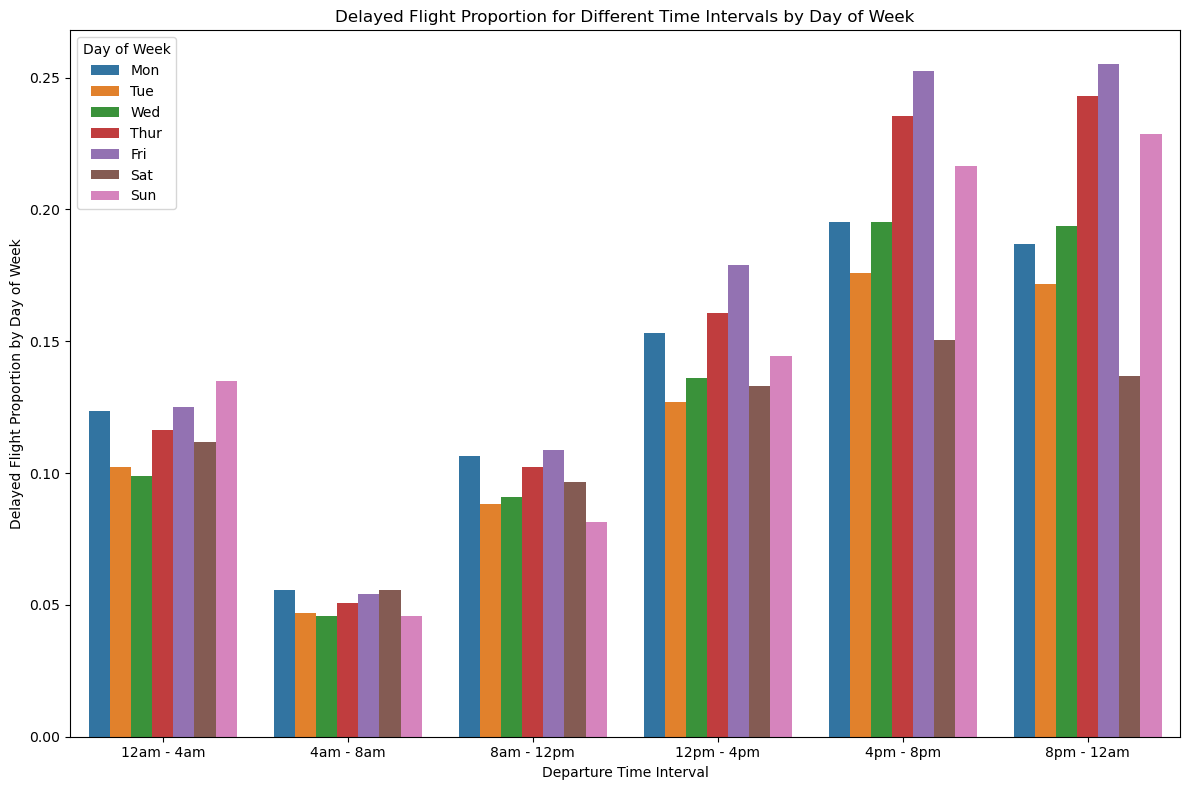

In [53]:
plt.figure(figsize=(12, 8))
sns.barplot(x='DepartureBins', y='DelayProp', hue='DayOfWeek', data=delayed_proportion_summary_by_interval)
plt.title('Delayed Flight Proportion for Different Time Intervals by Day of Week')
plt.xlabel('Departure Time Interval')
plt.ylabel('Delayed Flight Proportion by Day of Week')
plt.legend(title='Day of Week')
plt.tight_layout()
plt.show()

We will also create a summary for the mean total delay by different time intervals and day of the week to evaluate which time interval has the lowest average total delay.

In [54]:
mean_delay_summary_by_interval = flights_subset_1.groupby(['DayOfWeek', 'DepartureBins'])['Total_Delay'].mean().reset_index(name='MeanTotalDelay')

print(mean_delay_summary_by_interval)


   DayOfWeek DepartureBins  MeanTotalDelay
0        Mon    12am - 4am        6.692148
1        Mon     4am - 8am        1.998126
2        Mon    8am - 12pm        5.238459
3        Mon    12pm - 4pm        8.913883
4        Mon     4pm - 8pm       12.431171
5        Mon    8pm - 12am       10.758825
6        Tue    12am - 4am        4.419448
7        Tue     4am - 8am        0.801378
8        Tue    8am - 12pm        3.401521
9        Tue    12pm - 4pm        6.647089
10       Tue     4pm - 8pm       10.793758
11       Tue    8pm - 12am        9.368997
12       Wed    12am - 4am        4.581869
13       Wed     4am - 8am        0.825839
14       Wed    8am - 12pm        3.888292
15       Wed    12pm - 4pm        7.694000
16       Wed     4pm - 8pm       12.825535
17       Wed    8pm - 12am       11.455206
18      Thur    12am - 4am        6.432929
19      Thur     4am - 8am        1.608533
20      Thur    8am - 12pm        5.113626
21      Thur    12pm - 4pm        9.960252
22      Thu

Similar to the delay proportion analysis, the assessment of mean total delay also indicates that the time interval from 4 am to 8 am remains the optimal time to travel, displaying both the lowest delay proportion and total delay consistently across different days of the week.

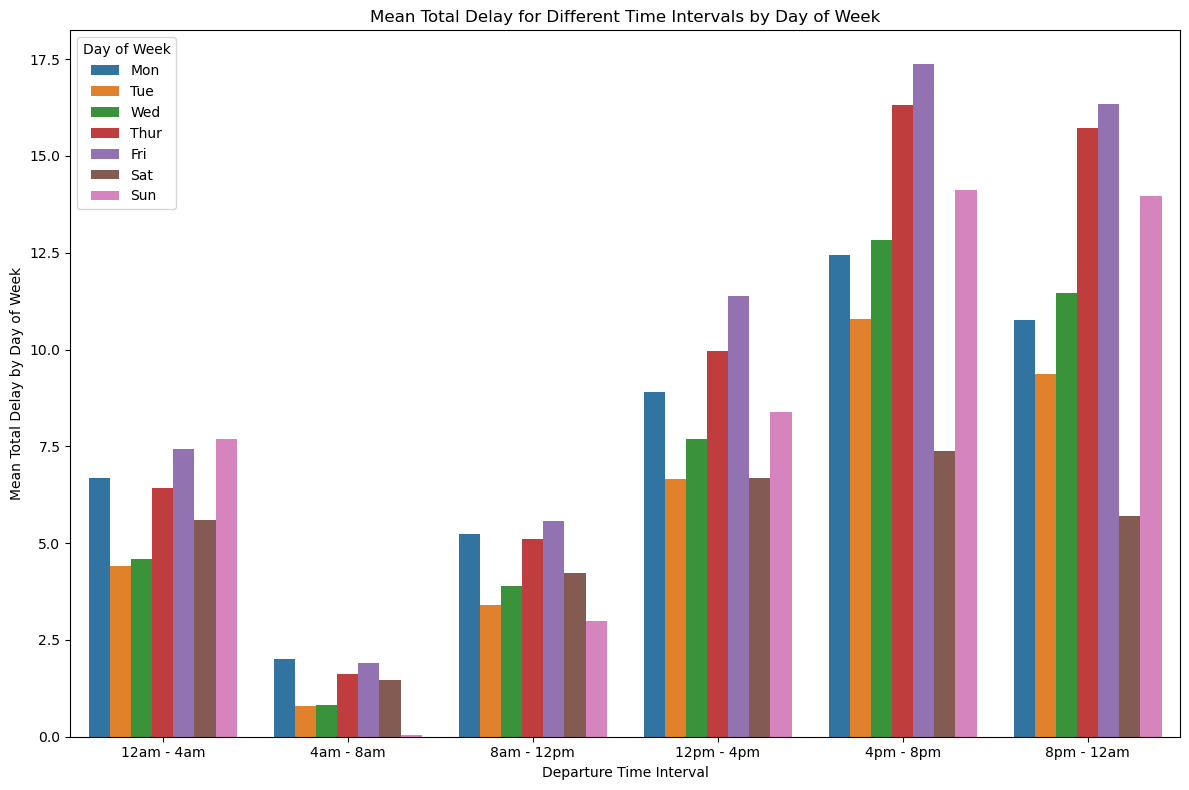

In [55]:
plt.figure(figsize=(12, 8))
sns.barplot(x='DepartureBins', y='MeanTotalDelay', hue='DayOfWeek', data=mean_delay_summary_by_interval)
plt.title('Mean Total Delay for Different Time Intervals by Day of Week')
plt.xlabel('Departure Time Interval')
plt.ylabel('Mean Total Delay by Day of Week')
plt.legend(title='Day of Week')
plt.tight_layout()
plt.show()

We'll create a summary to observe if the time interval from 4 am to 8 am consistently exhibits the lowest delay proportion across different years

In [56]:
delayed_proportion_summary_by_interval_and_year = flights_subset_1.groupby(['Year', 'DepartureBins']).apply(lambda x: np.mean((x['DepDelay'] > 15) & (x['ArrDelay'] > 15))).reset_index(name='DelayProp')

print(delayed_proportion_summary_by_interval_and_year)

    Year DepartureBins  DelayProp
0   1998    12am - 4am   0.105500
1   1998     4am - 8am   0.047146
2   1998    8am - 12pm   0.095668
3   1998    12pm - 4pm   0.134847
4   1998     4pm - 8pm   0.187600
5   1998    8pm - 12am   0.193714
6   1999    12am - 4am   0.126403
7   1999     4am - 8am   0.048068
8   1999    8am - 12pm   0.096768
9   1999    12pm - 4pm   0.145954
10  1999     4pm - 8pm   0.203811
11  1999    8pm - 12am   0.201835
12  2000    12am - 4am   0.158223
13  2000     4am - 8am   0.057944
14  2000    8am - 12pm   0.118133
15  2000    12pm - 4pm   0.177917
16  2000     4pm - 8pm   0.241255
17  2000    8pm - 12am   0.242358
18  2001    12am - 4am   0.090928
19  2001     4am - 8am   0.049777
20  2001    8am - 12pm   0.094705
21  2001    12pm - 4pm   0.138821
22  2001     4pm - 8pm   0.179729
23  2001    8pm - 12am   0.176962
24  2002    12am - 4am   0.062410
25  2002     4am - 8am   0.038636
26  2002    8am - 12pm   0.069873
27  2002    12pm - 4pm   0.107557
28  2002     4

The visualization indicates that 4am - 8am has the lowest delay proportion throughout the years.

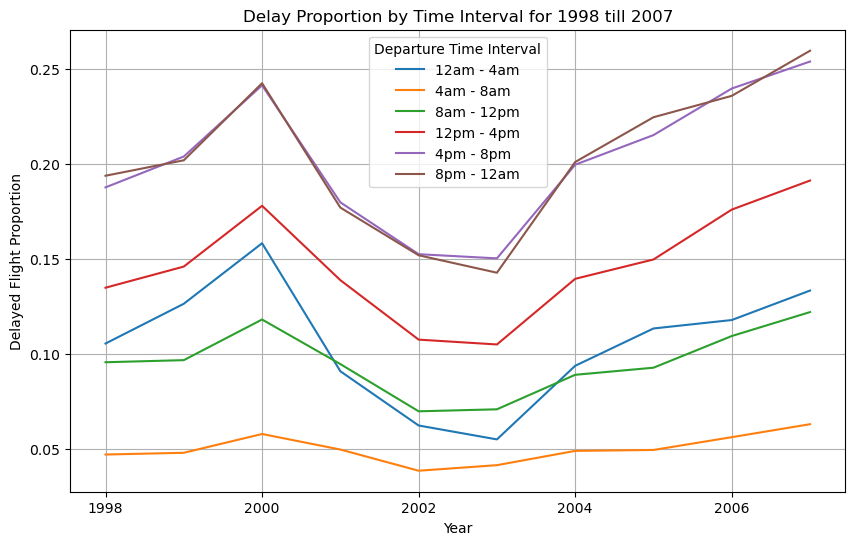

In [57]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=delayed_proportion_summary_by_interval_and_year, x='Year', y='DelayProp', hue='DepartureBins')
plt.title('Delay Proportion by Time Interval for 1998 till 2007')
plt.xlabel('Year')
plt.ylabel('Delayed Flight Proportion')
plt.legend(title='Departure Time Interval')
plt.grid(True)
plt.show()

We'll create a summary to observe if the time interval from 4 am to 8 am consistently exhibits the lowest mean delay across different years.

In [58]:
mean_total_delay_summary_by_interval_and_year = flights_subset_1.groupby(['Year', 'DepartureBins'])['Total_Delay'].mean().reset_index(name='MeanTotalDelay')

print(mean_total_delay_summary_by_interval_and_year)

    Year DepartureBins  MeanTotalDelay
0   1998    12am - 4am        5.119575
1   1998     4am - 8am        2.273792
2   1998    8am - 12pm        5.389488
3   1998    12pm - 4pm        8.454395
4   1998     4pm - 8pm       12.984525
5   1998    8pm - 12am       12.302755
6   1999    12am - 4am        7.892033
7   1999     4am - 8am        1.920063
8   1999    8am - 12pm        5.287823
9   1999    12pm - 4pm        9.344822
10  1999     4pm - 8pm       14.103603
11  1999    8pm - 12am       12.650424
12  2000    12am - 4am        8.759435
13  2000     4am - 8am        2.767595
14  2000    8am - 12pm        6.909195
15  2000    12pm - 4pm       11.551209
16  2000     4pm - 8pm       16.801367
17  2000    8pm - 12am       15.599928
18  2001    12am - 4am        4.710631
19  2001     4am - 8am        1.273689
20  2001    8am - 12pm        4.173938
21  2001    12pm - 4pm        7.624633
22  2001     4pm - 8pm       10.835327
23  2001    8pm - 12am        9.671293
24  2002    12am - 4am   

Visual suggests that the time interval from 4 am to 8 am generally has the lowest mean delay throughout the years, except for 2002 and 2003, where there is a crossover, and the time interval from 12 am to 4 am exhibits the lowest mean delay.

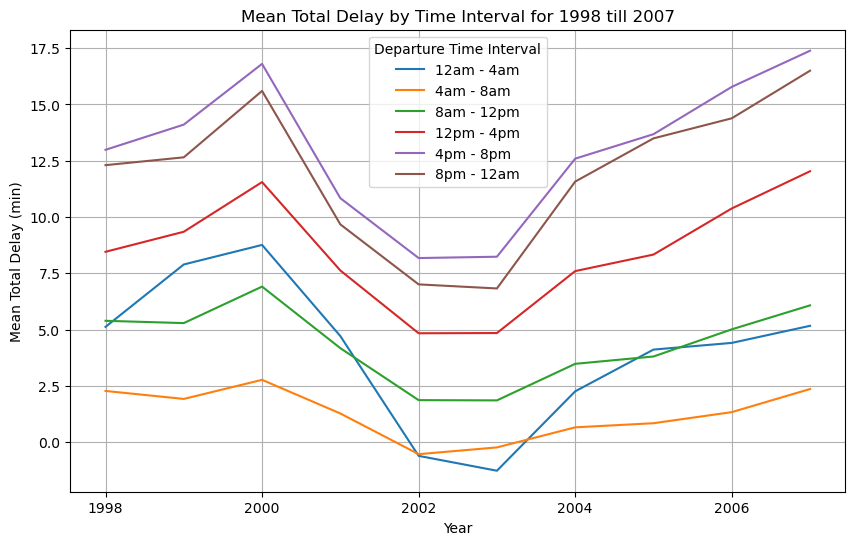

In [59]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=mean_total_delay_summary_by_interval_and_year, x='Year', y='MeanTotalDelay', hue='DepartureBins')
plt.title('Mean Total Delay by Time Interval for 1998 till 2007')
plt.xlabel('Year')
plt.ylabel('Mean Total Delay (min)')
plt.legend(title='Departure Time Interval')
plt.grid(True)
plt.show()

We'll group the data by scheduled departure hour and summarize the mean delay across different scheduled departure hours.

In [60]:
flights_subset_1['hour'] = np.where((flights_subset_1['CRSDepTime'] // 100 == 24), 0, flights_subset_1['CRSDepTime'] // 100)
flights_subset_1_mean_delay = flights_subset_1.groupby('hour')['Total_Delay'].mean().reset_index(name='MeanTotalDelay').sort_values(by='MeanTotalDelay')

print(flights_subset_1_mean_delay)

    hour  MeanTotalDelay
5      5        0.473357
6      6        0.731357
2      2        1.810990
7      7        1.840800
1      1        3.016215
8      8        3.030309
9      9        3.963530
3      3        4.161370
10    10        4.904136
4      4        5.679291
11    11        5.692171
12    12        6.488644
0      0        6.775401
23    23        7.904223
13    13        7.907974
22    22        8.924363
14    14        9.242282
15    15       10.614154
16    16       11.621804
21    21       12.494373
17    17       13.285759
18    18       13.534664
20    20       13.760597
19    19       14.342870


The visualization suggests that the optimal time to fly to minimize delay is around 5 am. Additionally, we observe that delays gradually increase and peak around 6 pm. This pattern aligns with the phenomenon where delays from earlier flights can cascade and affect subsequent flights, leading to increased delays as the day progresses.

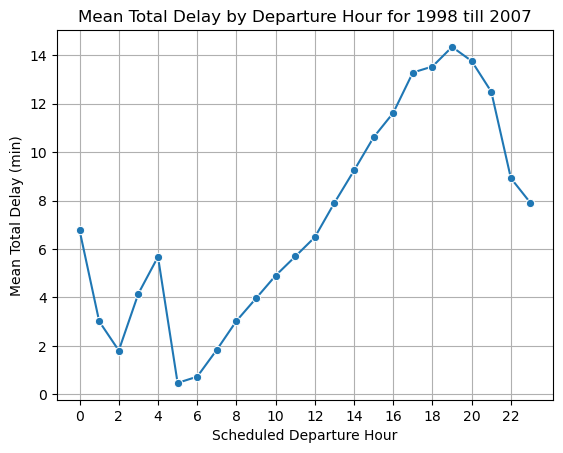

In [61]:
sns.lineplot(data=flights_subset_1_mean_delay, x='hour', y='MeanTotalDelay', marker='o')
plt.xlabel('Scheduled Departure Hour')
plt.ylabel('Mean Total Delay (min)')
plt.title('Mean Total Delay by Departure Hour for 1998 till 2007')
plt.xticks(range(0, 24, 2))
plt.grid(True)
plt.show()

We'll group the data by scheduled departure hour and summarize the delay proportion across different scheduled departure hours.

In [62]:
flights_subset_1['hour'] = flights_subset_1['CRSDepTime'] // 100
flights_subset_1['hour'] = flights_subset_1['hour'].apply(lambda x: 0 if x == 24 else x)

flights_subset_1_delay_proportion = flights_subset_1.groupby('hour').apply(lambda x: np.mean((x['DepDelay'] > 15) & (x['ArrDelay'] > 15))).reset_index(name='DelayProp')

print(flights_subset_1_delay_proportion)

    hour  DelayProp
0      0   0.120343
1      1   0.097230
2      2   0.088485
3      3   0.115068
4      4   0.123002
5      5   0.039629
6      6   0.043367
7      7   0.058428
8      8   0.075445
9      9   0.090956
10    10   0.105162
11    11   0.116583
12    12   0.124957
13    13   0.139169
14    14   0.155814
15    15   0.172236
16    16   0.184495
17    17   0.203585
18    18   0.209280
19    19   0.221469
20    20   0.220932
21    21   0.212608
22    22   0.167397
23    23   0.155818


Plot reveals that 5am is the best time to fly with minimal flights delay.

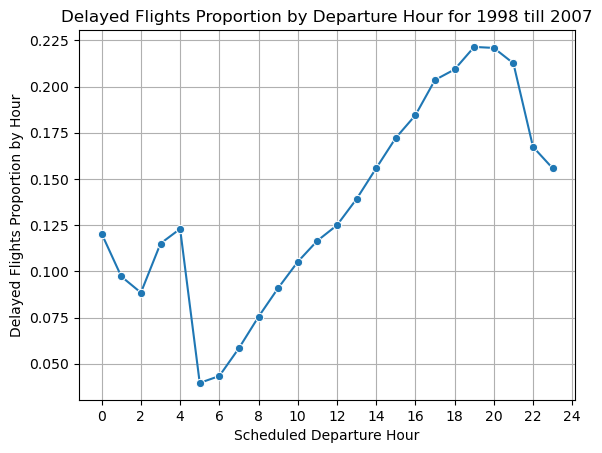

In [63]:
sns.lineplot(data=flights_subset_1_delay_proportion, x='hour', y='DelayProp', marker='o')
plt.xlabel('Scheduled Departure Hour')
plt.ylabel('Delayed Flights Proportion by Hour')
plt.title('Delayed Flights Proportion by Departure Hour for 1998 till 2007')
plt.xticks(range(0, 25, 2))
plt.grid(True)
plt.show()

### Which day of week is the best time to fly to minimize delay?

We'll create a summary of delay proportion grouped by day of the week and month to visualize the day of the week with the lowest delay proportion.

In [64]:
delayed_proportion_by_dayofweek = flights_subset_1.groupby(['DayOfWeek', 'Month']).apply(lambda x: np.mean((x['DepDelay'] > 15) & (x['ArrDelay'] > 15))).reset_index(name='DelayProp')

print(delayed_proportion_by_dayofweek)

   DayOfWeek Month  DelayProp
0        Mon   Jan   0.163803
1        Mon   Feb   0.145396
2        Mon   Mar   0.127876
3        Mon   Apr   0.120308
4        Mon   May   0.119574
..       ...   ...        ...
79       Sun   Aug   0.157716
80       Sun   Sep   0.107306
81       Sun   Oct   0.126345
82       Sun   Nov   0.136838
83       Sun   Dec   0.172676

[84 rows x 3 columns]


Through the heatmap, we observe that Saturday is the best day to fly for minimal delay proportion. The results are also fairly consistent across different months.

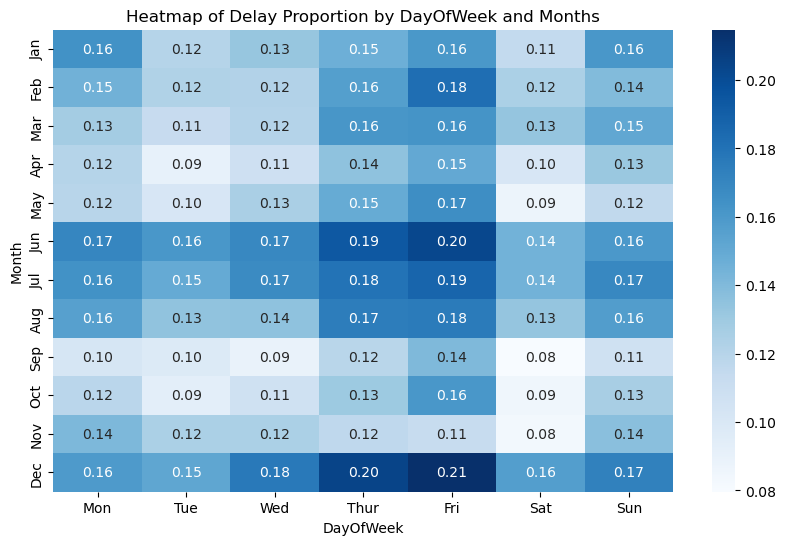

In [65]:
plt.figure(figsize=(10, 6))
sns.heatmap(data=delayed_proportion_by_dayofweek.pivot_table(index='Month', columns='DayOfWeek', values='DelayProp'), cmap='Blues', annot=True, fmt=".2f")
plt.title('Heatmap of Delay Proportion by DayOfWeek and Months')
plt.xlabel('DayOfWeek')
plt.ylabel('Month')
plt.show()

A summary of delay proportion by day of week is created to evaluate the best day to fly for minimal delay.

In [66]:
delayed_proportion_by_dayofweek = flights_subset_1.groupby(['DayOfWeek']).apply(lambda x: np.mean((x['DepDelay'] > 15) & (x['ArrDelay'] > 15))).reset_index(name='DelayProp')

print(delayed_proportion_by_dayofweek)

  DayOfWeek  DelayProp
0       Mon   0.140623
1       Tue   0.121953
2       Wed   0.131768
3      Thur   0.156046
4       Fri   0.168465
5       Sat   0.116230
6       Sun   0.144378


The bar plot shows that Saturday indeed is the best day of the week to fly with the lowest delay proportion.

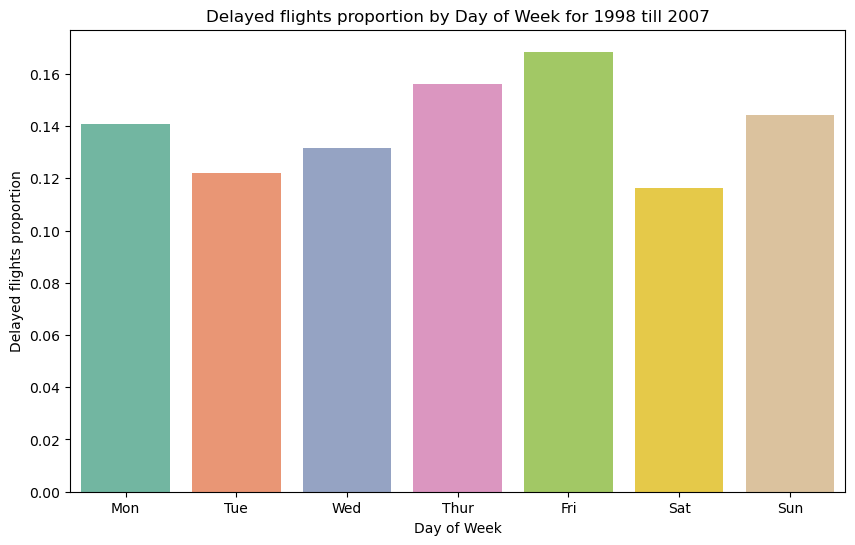

In [67]:
plt.figure(figsize=(10, 6))
sns.barplot(data=delayed_proportion_by_dayofweek, x='DayOfWeek', y='DelayProp', palette='Set2')
plt.title('Delayed flights proportion by Day of Week for 1998 till 2007')
plt.xlabel('Day of Week')
plt.ylabel('Delayed flights proportion')
plt.grid(False)
plt.show()

A summary of delay proportion by day of week and year is created to evaluate the best day to fly across different years to minimize delay.

In [68]:
delayed_proportion_by_dayofweek_and_year = flights_subset_1.groupby(['DayOfWeek', 'Year']).apply(lambda x: np.mean((x['DepDelay'] > 15) & (x['ArrDelay'] > 15))).reset_index(name='DelayProp')
print(delayed_proportion_by_dayofweek_and_year)

   DayOfWeek  Year  DelayProp
0        Mon  1998   0.125247
1        Mon  1999   0.135590
2        Mon  2000   0.157078
3        Mon  2001   0.113887
4        Mon  2002   0.104432
..       ...   ...        ...
65       Sun  2003   0.107655
66       Sun  2004   0.135966
67       Sun  2005   0.142065
68       Sun  2006   0.162403
69       Sun  2007   0.181621

[70 rows x 3 columns]


Saturday remains as the best day of week to fly for minimal delay since 2002.

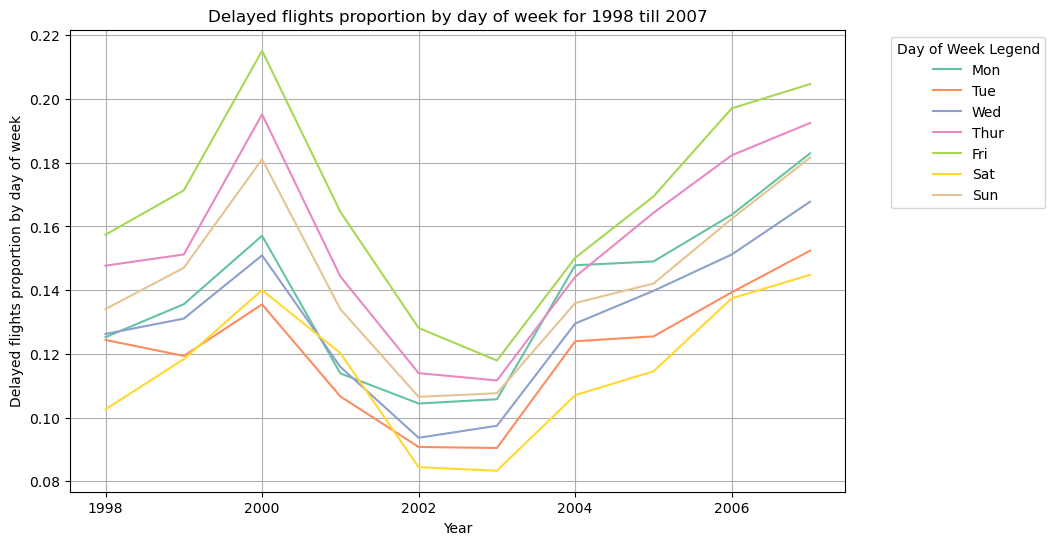

In [69]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=delayed_proportion_by_dayofweek_and_year, x='Year', y='DelayProp', hue='DayOfWeek', palette='Set2')
plt.title('Delayed flights proportion by day of week for 1998 till 2007')
plt.xlabel('Year')
plt.ylabel('Delayed flights proportion by day of week')
plt.xticks(range(1998, 2008, 2))
plt.grid(True)
plt.legend(title='Day of Week Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

A summary of mean delay by day of week and month is created to evaluate the best day to fly across different month to minimize delay.

In [70]:
mean_delay_by_dayofweek = flights_subset_1.groupby(['DayOfWeek', 'Month']).agg(MeanDelay=('Total_Delay', 'mean')).reset_index()

print(mean_delay_by_dayofweek)

   DayOfWeek Month  MeanDelay
0        Mon   Jan   9.790045
1        Mon   Feb   8.073994
2        Mon   Mar   6.778065
3        Mon   Apr   6.039683
4        Mon   May   6.403784
..       ...   ...        ...
79       Sun   Aug   9.548178
80       Sun   Sep   4.314886
81       Sun   Oct   6.076180
82       Sun   Nov   7.433325
83       Sun   Dec  10.381903

[84 rows x 3 columns]


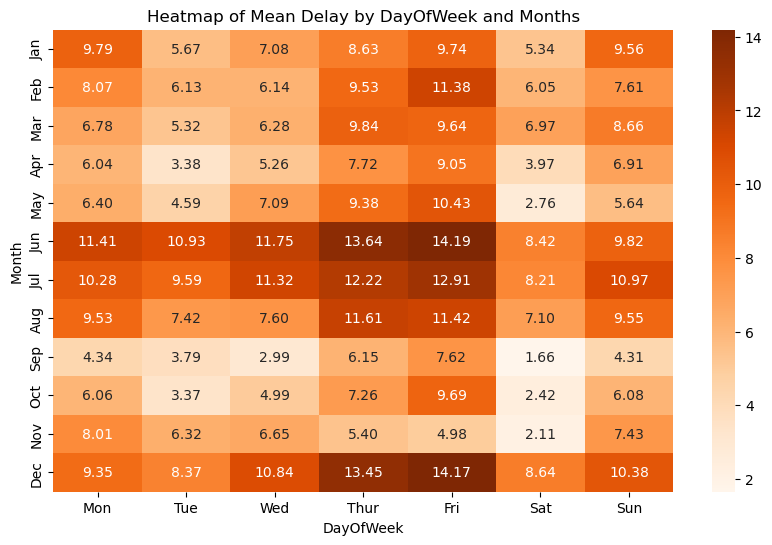

In [71]:
plt.figure(figsize=(10, 6))
sns.heatmap(data=mean_delay_by_dayofweek.pivot_table(index='Month', columns='DayOfWeek', values='MeanDelay'), cmap='Oranges', annot=True, fmt=".2f")
plt.title('Heatmap of Mean Delay by DayOfWeek and Months')
plt.xlabel('DayOfWeek')
plt.ylabel('Month')
plt.show()

A summary of mean delay by day of week is created to evaluate the best day to fly for minimal delay.

In [72]:
mean_delay_by_dayofweek = flights_subset_1.groupby('DayOfWeek')['Total_Delay'].mean().reset_index()

print(mean_delay_by_dayofweek)

  DayOfWeek  Total_Delay
0       Mon     8.015238
1       Tue     6.255744
2       Wed     7.355615
3      Thur     9.617367
4       Fri    10.477744
5       Sat     5.353889
6       Sun     8.105762


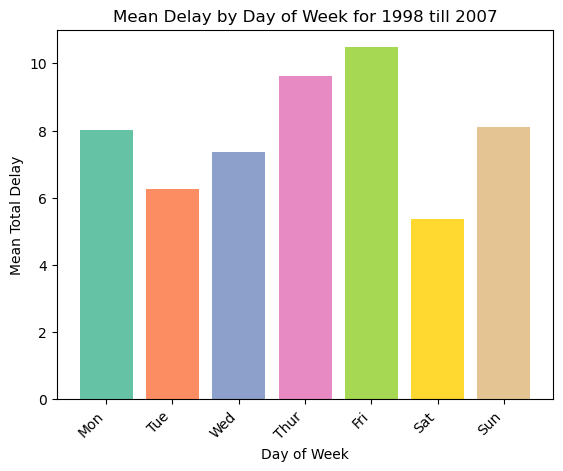

In [73]:
plt.bar(mean_delay_by_dayofweek['DayOfWeek'], mean_delay_by_dayofweek['Total_Delay'], color=sns.color_palette('Set2'))
plt.title('Mean Delay by Day of Week for 1998 till 2007')
plt.xlabel('Day of Week')
plt.ylabel('Mean Total Delay')
plt.xticks(rotation=45, ha='right')
plt.grid(False)
plt.show()

A summary of mean delay by day of week and year is created to evaluate the best day to fly across different years to minimize delay.

In [74]:
mean_delay_by_dayofweek_and_year = flights_subset_1.groupby(['DayOfWeek', 'Year']).agg(MeanDelay=('Total_Delay', 'mean')).reset_index()

print(mean_delay_by_dayofweek)

  DayOfWeek  Total_Delay
0       Mon     8.015238
1       Tue     6.255744
2       Wed     7.355615
3      Thur     9.617367
4       Fri    10.477744
5       Sat     5.353889
6       Sun     8.105762


Saturday remains as the best day of week to fly for minimal mean delay since 2002.

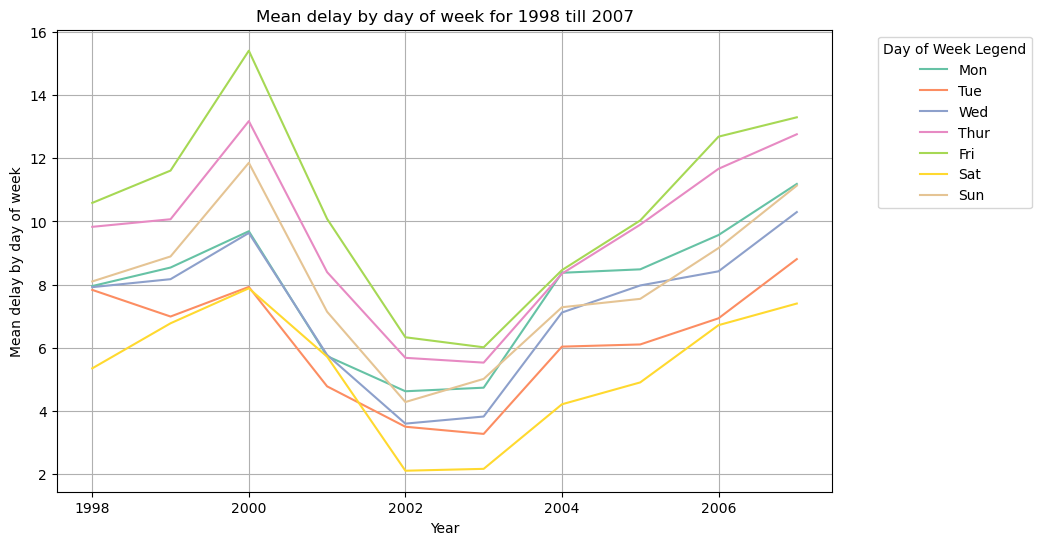

In [75]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=mean_delay_by_dayofweek_and_year, x='Year', y='MeanDelay', hue='DayOfWeek', palette='Set2')
plt.title('Mean delay by day of week for 1998 till 2007')
plt.xlabel('Year')
plt.ylabel('Mean delay by day of week')
plt.xticks(range(1998, 2008, 2))
plt.grid(True)
plt.legend(title='Day of Week Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### When is the best month to fly to minimize delay?

To evaluate which is the best month to fly to minimize delay, we will create a summary of delay proportion by month.

In [76]:
delayed_proportion_by_month = flights_subset_1.groupby('Month').apply(lambda x: np.mean((x['DepDelay'] > 15) & (x['ArrDelay'] > 15))).reset_index(name='DelayProp')
delayed_proportion_by_month['Month'] = delayed_proportion_by_month['Month'].cat.reorder_categories(delayed_proportion_by_month.sort_values('DelayProp')['Month'], ordered=True)
delayed_proportion_by_month = delayed_proportion_by_month.sort_values('DelayProp')

print(delayed_proportion_by_month)

   Month  DelayProp
8    Sep   0.105700
9    Oct   0.118140
3    Apr   0.120073
10   Nov   0.120722
4    May   0.124085
2    Mar   0.138842
1    Feb   0.142213
0    Jan   0.143410
7    Aug   0.152745
6    Jul   0.166121
5    Jun   0.172539
11   Dec   0.177388


We observe that September has the lowest delay proportion.

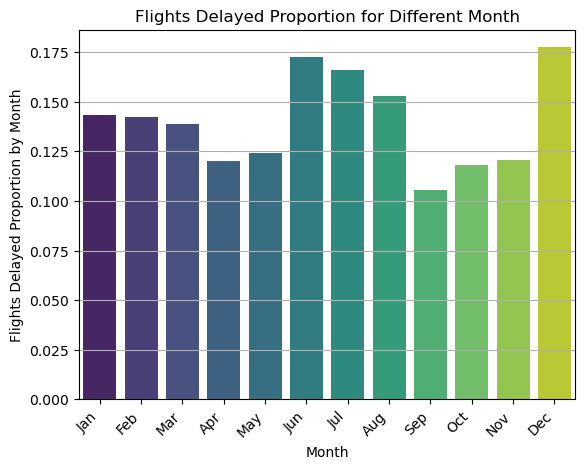

In [77]:
sns.barplot(data=delayed_proportion_by_month, x='Month', y='DelayProp', palette='viridis')
plt.title('Flights Delayed Proportion for Different Month')
plt.xlabel('Month')
plt.ylabel('Flights Delayed Proportion by Month')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

A summary of mean delay by month is also created to evaluate the best month to fly for minimal delay.

In [78]:
mean_total_delay_by_month = flights_subset_1.groupby('Month')['Total_Delay'].mean().reset_index()

print(mean_total_delay_by_month)

   Month  Total_Delay
0    Jan     8.023673
1    Feb     7.889580
2    Mar     7.662011
3    Apr     6.103514
4    May     6.685040
5    Jun    11.529727
6    Jul    10.808876
7    Aug     9.210803
8    Sep     4.471577
9    Oct     5.761176
10   Nov     5.923367
11   Dec    10.808007


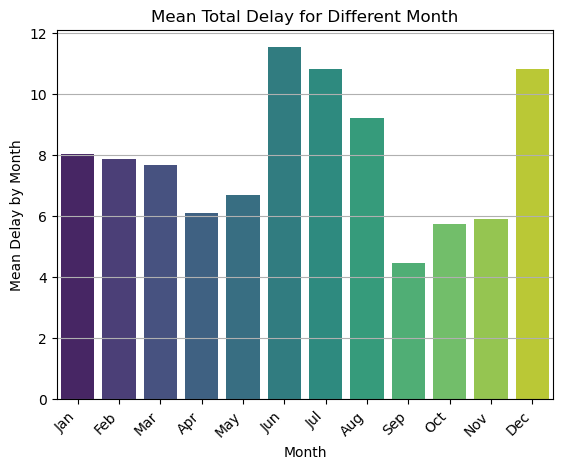

In [79]:
sns.barplot(data=mean_total_delay_by_month, x='Month', y='Total_Delay', palette='viridis')
plt.title('Mean Total Delay for Different Month')
plt.xlabel('Month')
plt.ylabel('Mean Delay by Month')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

We aim to assess whether the trend of September being the month with minimal delay is consistent across different years. A summary of delay proportion by month and year is created for our analysis.

In [80]:
delayed_proportion_by_month_and_year = flights_subset_1.groupby(['Month', 'Year']).apply(lambda x: np.mean((x['DepDelay'] > 15) & (x['ArrDelay'] > 15))).reset_index(name='DelayProp')

print(delayed_proportion_by_month_and_year)

    Month  Year  DelayProp
0     Jan  1998   0.141922
1     Jan  1999   0.193171
2     Jan  2000   0.139059
3     Jan  2001   0.141723
4     Jan  2002   0.100913
..    ...   ...        ...
115   Dec  2003   0.141721
116   Dec  2004   0.185995
117   Dec  2005   0.190576
118   Dec  2006   0.196942
119   Dec  2007   0.237492

[120 rows x 3 columns]


The line chart displays several crossovers between different months; however, September and October consistently maintain one of the lowest proportions across different years.

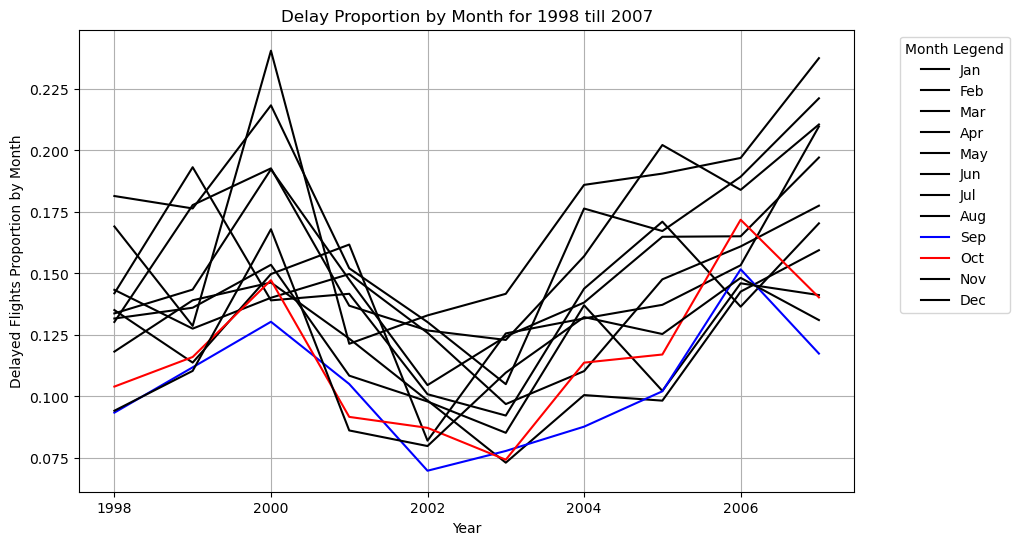

In [81]:
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
custom_palette = {"Sep": "blue", "Oct": "red"}

# Create a color dictionary for all months
color_dict = {month: custom_palette.get(month, "black") for month in month_order}

plt.figure(figsize=(10, 6))
sns.lineplot(data=delayed_proportion_by_month_and_year, x='Year', y='DelayProp', hue='Month', palette=color_dict)
plt.title('Delay Proportion by Month for 1998 till 2007')
plt.xlabel('Year')
plt.ylabel('Delayed Flights Proportion by Month')
plt.xticks(range(1998, 2008, 2))
plt.grid(True)
plt.legend(title='Month Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [82]:
mean_total_delay_by_month_and_year = flights_subset_1.groupby(['Year', 'Month'])['Total_Delay'].mean().reset_index()

print(mean_total_delay_by_month_and_year)

     Year Month  Total_Delay
0    1998   Jan     8.876161
1    1998   Feb     8.420664
2    1998   Mar     9.051589
3    1998   Apr     7.431242
4    1998   May     8.845374
..    ...   ...          ...
115  2007   Aug    13.019398
116  2007   Sep     4.932207
117  2007   Oct     7.215500
118  2007   Nov     6.110063
119  2007   Dec    16.183152

[120 rows x 3 columns]


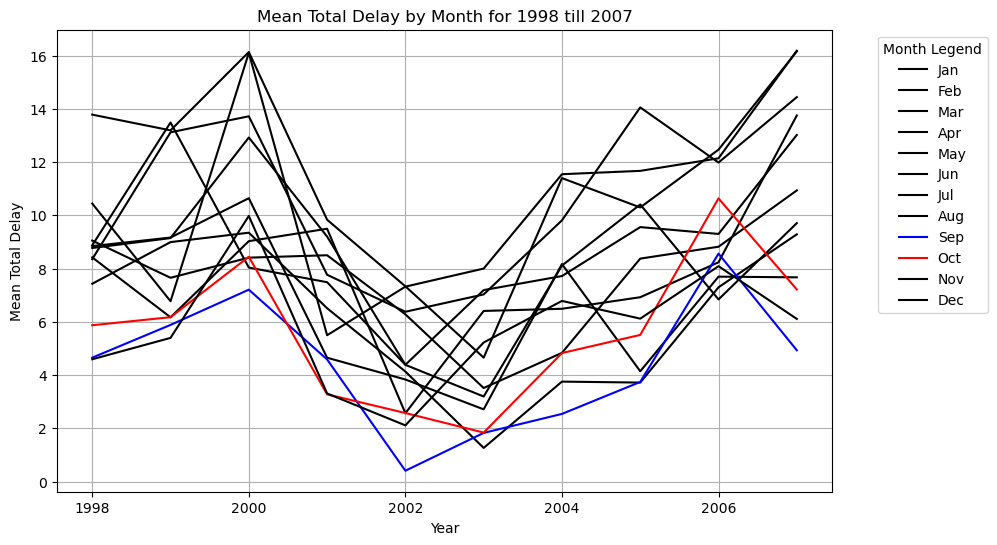

In [83]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=mean_total_delay_by_month_and_year, x='Year', y='Total_Delay', hue='Month', palette=color_dict)
plt.title('Mean Total Delay by Month for 1998 till 2007')
plt.xlabel('Year')
plt.ylabel('Mean Total Delay')
plt.xticks(range(1998, 2008, 2))
plt.grid(True)
plt.legend(title='Month Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## (b) Evaluate whether older planes suffer more delays on a year-to-year basis.

# 3.1 Data Cleaning

Selecting the variables we may need to address question 2b.

In [84]:
flights_subset_2 = df[(df['Cancelled'] == 0) & (df['Diverted'] == 0)]
flights_subset_2 = flights_subset_2[['Year', 'UniqueCarrier', 'DepDelay', 'ArrDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'TailNum']]

In [85]:
#Read plane-data.csv stored as object "planes"
planes = pd.read_csv("plane-data.csv")
planes  = planes.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

Combine flights and planes data frames containing all the rows of flights data. This will result in a data frame that contains planes information including the year it is issued, and it's manufacturer. We will need these information to address question 2b.

In [86]:
flights_subset_2 = flights_subset_2.merge(planes, how='left', left_on='TailNum', right_on='tailnum')

print(flights_subset_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61625194 entries, 0 to 61625193
Data columns (total 19 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   UniqueCarrier      object 
 2   DepDelay           float64
 3   ArrDelay           float64
 4   CarrierDelay       float64
 5   WeatherDelay       float64
 6   NASDelay           float64
 7   SecurityDelay      float64
 8   LateAircraftDelay  float64
 9   TailNum            object 
 10  tailnum            object 
 11  type               object 
 12  manufacturer       object 
 13  issue_date         object 
 14  model              object 
 15  status             object 
 16  aircraft_type      object 
 17  engine_type        object 
 18  year               float64
dtypes: float64(8), int64(1), object(10)
memory usage: 8.7+ GB
None


NAs are identified for multiple variables. We will replace NAs with 0 for "CarrierDelay", "LateAircraftDelay", "NASDelay", "WeatherDelay", "SecurityDelay".

In [87]:
flights_subset_2['CarrierDelay'].fillna(0, inplace=True)
flights_subset_2['NASDelay'].fillna(0, inplace=True)
flights_subset_2['SecurityDelay'].fillna(0, inplace=True)
flights_subset_2['WeatherDelay'].fillna(0, inplace=True)
flights_subset_2['LateAircraftDelay'].fillna(0, inplace=True)

We generate a pivot table summarizing the mean delay for each reason by year to investigate the presence of NAs. The table reveals that the mean delay is consistently 0 from 1998 to 2002, and the value for 2003 is not consistent with those from 2004 to 2007. This discrepancy suggests a possible reason: delays for each reason were not recorded before 2003.

In [88]:
flights_delay_summary_by_year = flights_subset_2.groupby('Year').agg({
    'CarrierDelay': 'mean',
    'NASDelay': 'mean',
    'SecurityDelay': 'mean',
    'WeatherDelay': 'mean',
    'LateAircraftDelay': 'mean'
}).reset_index()

# Rename columns for clarity
flights_delay_summary_by_year.columns = ['Year', 'CarrierDelay_Mean', 'NASDelay_Mean', 'SecurityDelay_Mean', 'WeatherDelay_Mean', 'LateAircraftDelay_Mean']

print(flights_delay_summary_by_year)

   Year  CarrierDelay_Mean  NASDelay_Mean  SecurityDelay_Mean  \
0  1998           0.000000       0.000000            0.000000   
1  1999           0.000000       0.000000            0.000000   
2  2000           0.000000       0.000000            0.000000   
3  2001           0.000000       0.000000            0.000000   
4  2002           0.000000       0.000000            0.000000   
5  2003           1.343892       1.860594            0.012652   
6  2004           2.695139       3.502191            0.025648   
7  2005           3.066259       3.438686            0.020170   
8  2006           3.463124       3.656690            0.031607   
9  2007           3.959775       3.876239            0.024316   

   WeatherDelay_Mean  LateAircraftDelay_Mean  
0           0.000000                0.000000  
1           0.000000                0.000000  
2           0.000000                0.000000  
3           0.000000                0.000000  
4           0.000000                0.000000  
5 

Check for missing values.

In [89]:
missing_summary = flights_subset_2.isnull().sum().reset_index()
missing_summary.columns = ['variable', 'missing_count']

print(missing_summary)

             variable  missing_count
0                Year              0
1       UniqueCarrier              0
2            DepDelay              0
3            ArrDelay              1
4        CarrierDelay              0
5        WeatherDelay              0
6            NASDelay              0
7       SecurityDelay              0
8   LateAircraftDelay              0
9             TailNum             58
10            tailnum       26086697
11               type       28501712
12       manufacturer       28501712
13         issue_date       28504365
14              model       28501712
15             status       28501712
16      aircraft_type       28501712
17        engine_type       28536858
18               year       29203094


Since the year of manufacture of the aircraft is necessary for our analysis, We will exclude observations with missing values from our analysis. These missing values are likely due to the lack of information about the aircraft operating those flights. 

In [90]:
flights_subset_2_NA_omit = flights_subset_2.dropna(subset=['tailnum', 'type', 'manufacturer', 'issue_date', 'model', 'status', 'aircraft_type', 'engine_type'])

Converting Issue_Date to date type so we can extract the hours for observations with missing "year" information.

In [91]:
flights_subset_2_NA_omit.loc[:, 'issue_date'] = pd.to_datetime(flights_subset_2_NA_omit['issue_date'], format='%m/%d/%Y')


Using issue date as "year" for observations without "year" information.

In [92]:
flights_subset_2_NA_omit.loc[:, 'year'] = flights_subset_2_NA_omit.apply(lambda row: row['issue_date'].year if pd.isnull(row['year']) else row['year'], axis=1)

In [93]:
#In this operation we drop NAs in 'year' and convert it to int datatype
flights_subset_2_NA_omit = flights_subset_2_NA_omit.dropna(subset=['year'])
flights_subset_2_NA_omit.loc[:, 'year'] = flights_subset_2_NA_omit['year'].astype(int)

Check missing value

In [94]:
missing_summary = flights_subset_2_NA_omit.isnull().sum().reset_index()
missing_summary.columns = ['variable', 'missing_count']

print(missing_summary)

             variable  missing_count
0                Year              0
1       UniqueCarrier              0
2            DepDelay              0
3            ArrDelay              1
4        CarrierDelay              0
5        WeatherDelay              0
6            NASDelay              0
7       SecurityDelay              0
8   LateAircraftDelay              0
9             TailNum              0
10            tailnum              0
11               type              0
12       manufacturer              0
13         issue_date              0
14              model              0
15             status              0
16      aircraft_type              0
17        engine_type              0
18               year              0


In [95]:
flights_subset_2_NA_omit.loc[:, 'PlaneAge'] = flights_subset_2_NA_omit['Year'] - flights_subset_2_NA_omit['year']


missing_count = flights_subset_2_NA_omit['PlaneAge'].isnull().sum()


summary = flights_subset_2_NA_omit['PlaneAge'].describe()


print("Summary of PlaneAge:")
print(summary)
print("\nCount of missing values in PlaneAge:", missing_count)


Summary of PlaneAge:
count    3.308568e+07
mean     1.049916e+01
std      5.245764e+01
min     -9.000000e+00
25%      4.000000e+00
50%      8.000000e+00
75%      1.300000e+01
max      2.007000e+03
Name: PlaneAge, dtype: float64

Count of missing values in PlaneAge: 0


Check variables data type

In [96]:
print(flights_subset_2_NA_omit.info())

<class 'pandas.core.frame.DataFrame'>
Index: 33085683 entries, 162 to 61625193
Data columns (total 20 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   UniqueCarrier      object 
 2   DepDelay           float64
 3   ArrDelay           float64
 4   CarrierDelay       float64
 5   WeatherDelay       float64
 6   NASDelay           float64
 7   SecurityDelay      float64
 8   LateAircraftDelay  float64
 9   TailNum            object 
 10  tailnum            object 
 11  type               object 
 12  manufacturer       object 
 13  issue_date         object 
 14  model              object 
 15  status             object 
 16  aircraft_type      object 
 17  engine_type        object 
 18  year               float64
 19  PlaneAge           float64
dtypes: float64(9), int64(1), object(10)
memory usage: 5.2+ GB
None


# 3.2 Data Exploration

The distributions indicate potential discrepancies in the "PlaneAge" and "year" variables from the negative and extreme values.

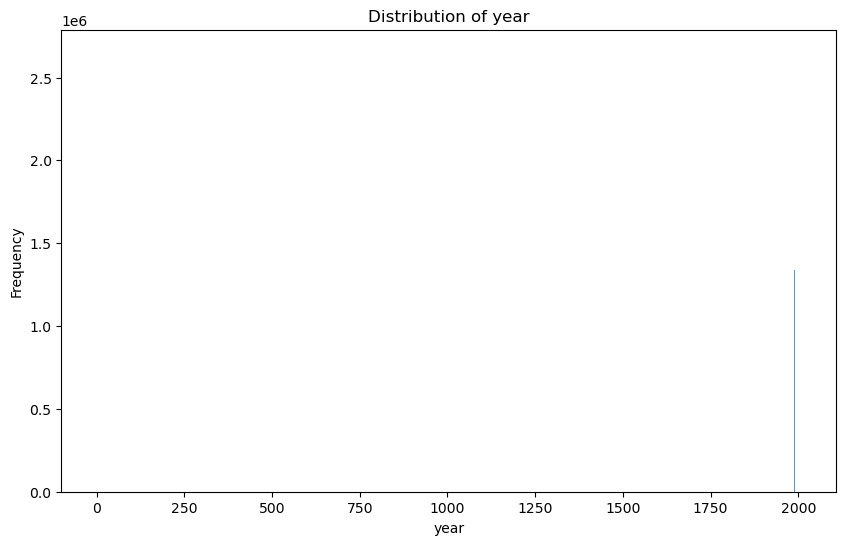

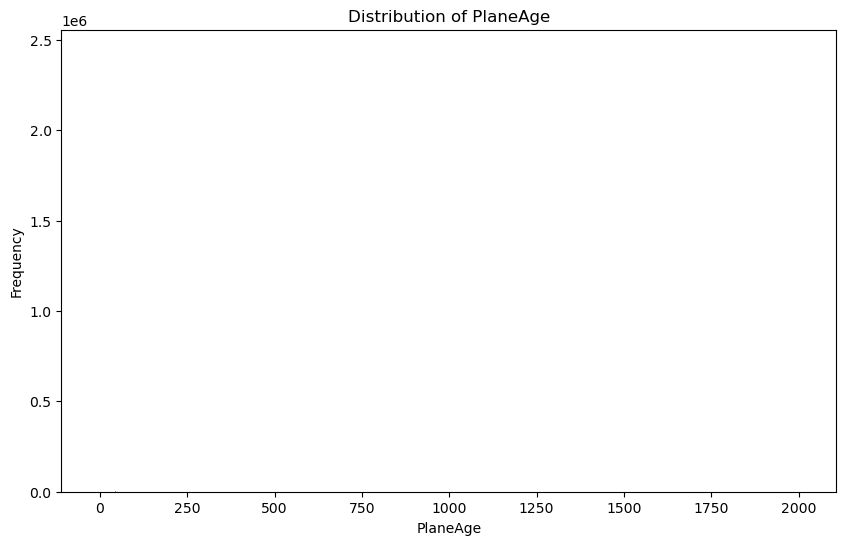

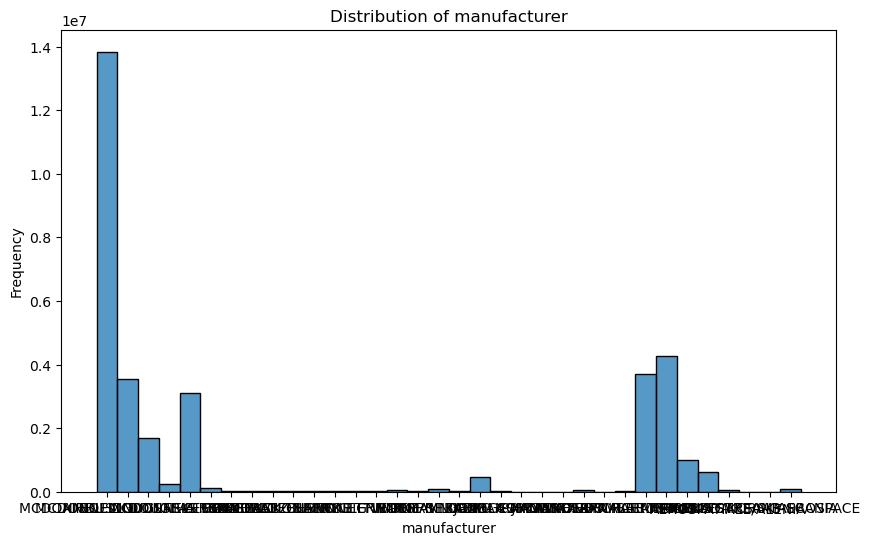

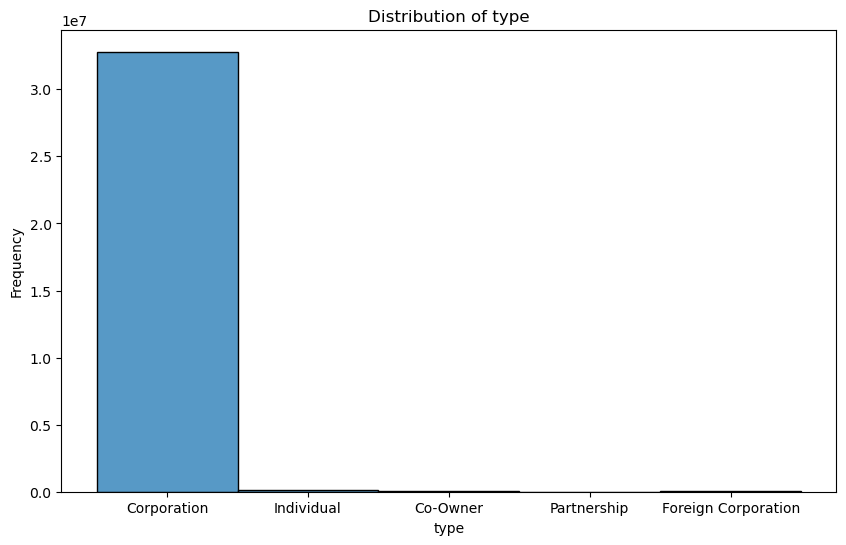

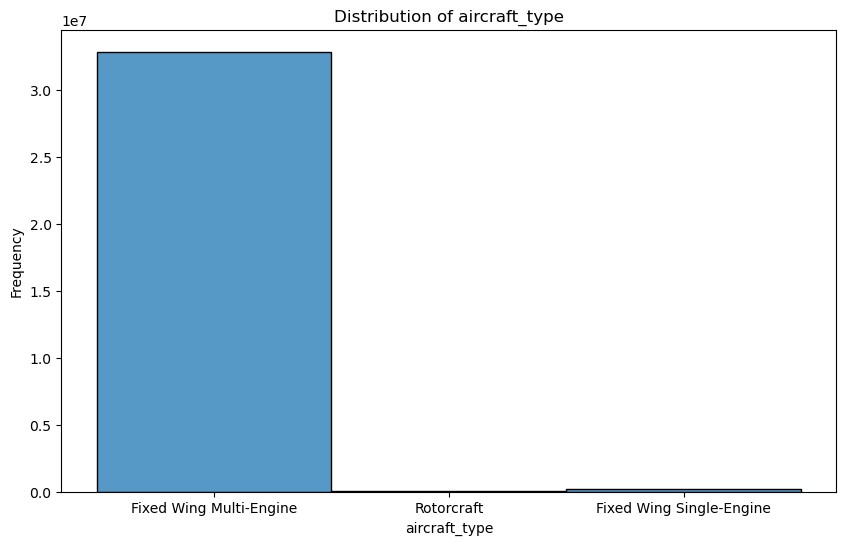

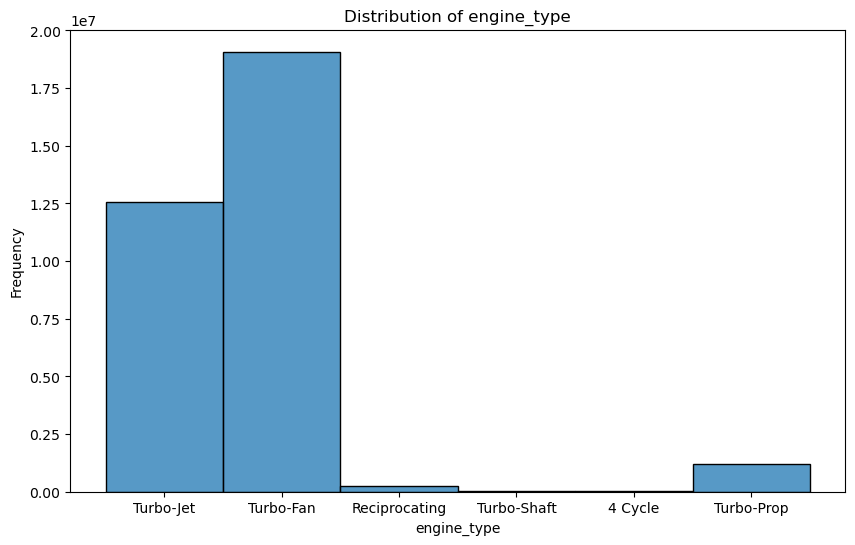

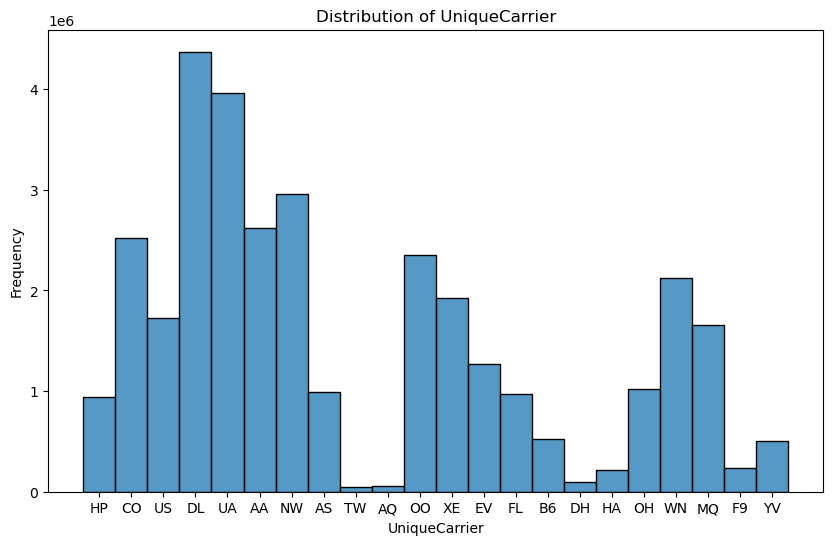

In [97]:
explore_distribution(flights_subset_2_NA_omit, ["year", "PlaneAge", "manufacturer", "type", "aircraft_type", "engine_type", "UniqueCarrier"])

We substitute zeroes in year variable for the year of issue date.

In [98]:
flights_subset_2_NA_omit.loc[:, 'year'] = flights_subset_2_NA_omit.apply(lambda row: row['issue_date'].year if row['year'] == 0 else row['year'], axis=1)

Since there is no alternative method to determine the year the aircraft was manufactured, we will need to exclude these observations from our analysis. We will additionally exclude observations with a plane age below 1, as it is not feasible for the age of an aircraft to be negative. This error may be due to discrepancies in data entry.

In [99]:
# Filter rows where PlaneAge is less than 52
flights_subset_2_NA_omit = flights_subset_2_NA_omit[flights_subset_2_NA_omit['PlaneAge'] < 53]

# Filter rows where PlaneAge is greater than 0
flights_subset_2_clean = flights_subset_2_NA_omit[flights_subset_2_NA_omit['PlaneAge'] > 0]

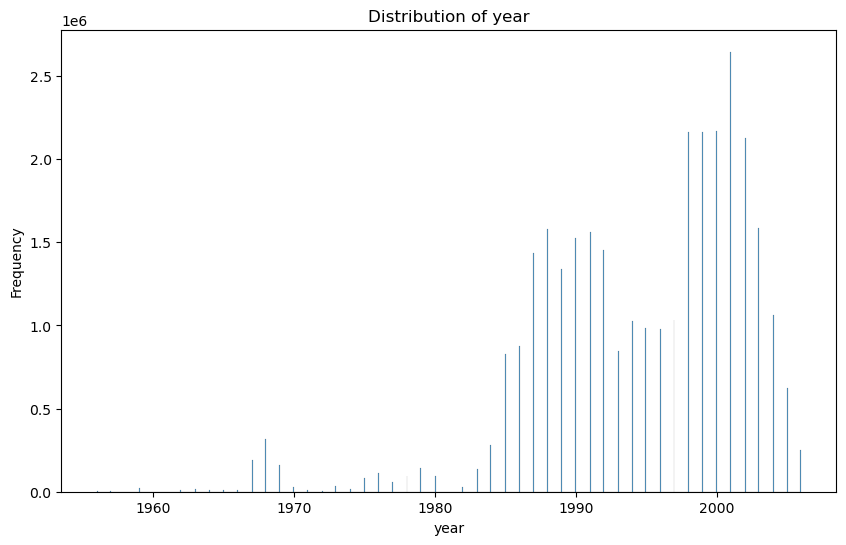

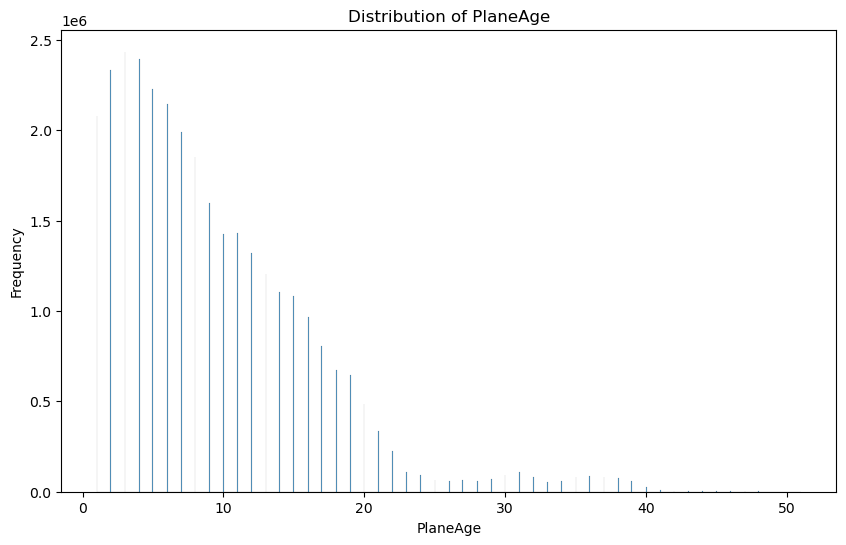

In [100]:
explore_distribution(flights_subset_2_clean, ["year", "PlaneAge"])

We aim to assess whether older aircraft experience higher delay proportions. We'll generate a summary presenting delay proportions across different aircraft ages.

In [101]:
delay_prop_planeage_summary = flights_subset_2_clean.groupby('PlaneAge').apply(lambda x: np.mean((x['ArrDelay'] > 15) & (x['DepDelay'] > 15))).reset_index(name='DelayProp')

print(delay_prop_planeage_summary)

    PlaneAge  DelayProp
0        1.0   0.134847
1        2.0   0.136023
2        3.0   0.137016
3        4.0   0.142532
4        5.0   0.144052
5        6.0   0.145003
6        7.0   0.146114
7        8.0   0.152760
8        9.0   0.153182
9       10.0   0.149822
10      11.0   0.142903
11      12.0   0.140917
12      13.0   0.143041
13      14.0   0.138174
14      15.0   0.139091
15      16.0   0.143811
16      17.0   0.146967
17      18.0   0.152469
18      19.0   0.159935
19      20.0   0.164503
20      21.0   0.164957
21      22.0   0.163058
22      23.0   0.144307
23      24.0   0.135409
24      25.0   0.137145
25      26.0   0.135761
26      27.0   0.144602
27      28.0   0.143363
28      29.0   0.136895
29      30.0   0.133774
30      31.0   0.126059
31      32.0   0.118866
32      33.0   0.106977
33      34.0   0.103268
34      35.0   0.091714
35      36.0   0.105307
36      37.0   0.120559
37      38.0   0.133264
38      39.0   0.145585
39      40.0   0.152707
40      41.0   0

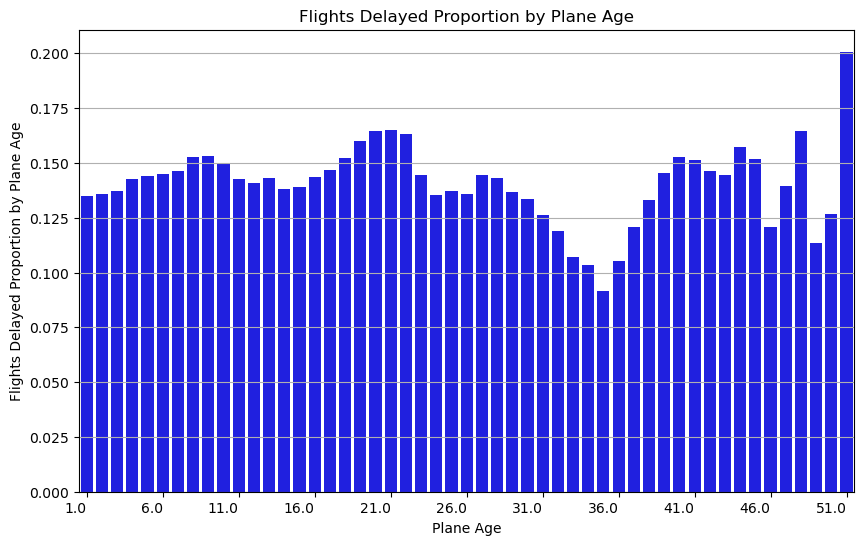

In [102]:
plt.figure(figsize=(10, 6))
sns.barplot(data=delay_prop_planeage_summary, x='PlaneAge', y='DelayProp', color='blue')
plt.title('Flights Delayed Proportion by Plane Age')
plt.xlabel('Plane Age')
plt.ylabel('Flights Delayed Proportion by Plane Age')
plt.xticks(range(0, int(max(delay_prop_planeage_summary['PlaneAge']))+1, 5), ha='right')
plt.grid(axis='y')
plt.show()

Creating a new column with Total_Delay column, which is the average of arrival and departure delay.

In [103]:
flights_subset_2_clean.loc[:, 'Total_Delay'] = (flights_subset_2_clean['ArrDelay'] + flights_subset_2_clean['DepDelay']) / 2

/var/folders/zs/wlhl2ll167973gq44w3m4c800000gn/T/ipykernel_6174/2980360527.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_subset_2_clean.loc[:, 'Total_Delay'] = (flights_subset_2_clean['ArrDelay'] + flights_subset_2_clean['DepDelay']) / 2


We fit a regression model to test the null hypothesis - There is no relationship between the age of aircraft and the total delay.

In [104]:
# Define the independent variable X (plane age) and dependent variable y (total delay) 
X = flights_subset_2_clean['PlaneAge'] 
y = flights_subset_2_clean['Total_Delay']  

# adding intercept
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Generate model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Total_Delay   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 31 Mar 2024   Prob (F-statistic):                nan
Time:                        21:07:11   Log-Likelihood:                    nan
No. Observations:            32144167   AIC:                               nan
Df Residuals:                32144165   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        n

A correlation matrix was generated to examine the relationships between variables. We found moderate to strong correlations between Total Delay and both Carrier and Late Aircraft Delay. Interestingly, we also noted a very weak correlation of 0.01 between Total Delay and Plane Age.

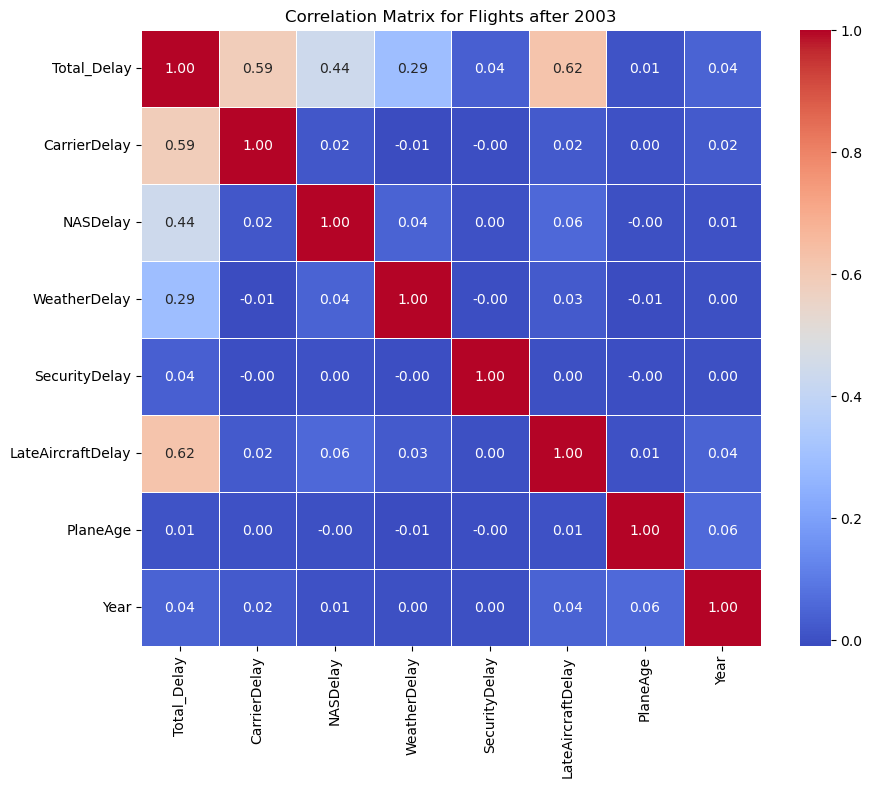

P-value for correlation between Plane Age and Total Delay: 6.654886714766432e-256


In [105]:
selected_columns = flights_subset_2_clean[flights_subset_2_clean['Year'] > 2003][['Total_Delay', 'CarrierDelay', 'NASDelay', 'WeatherDelay', 'SecurityDelay', 'LateAircraftDelay', 'PlaneAge', 'Year']]

# Compute correlation matrix
correlation_matrix = selected_columns.corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix for Flights after 2003')
plt.show()

correlation_coefficient, p_value = pearsonr(selected_columns['PlaneAge'], selected_columns['Total_Delay'])
print("P-value for correlation between Plane Age and Total Delay:", p_value)

To evaluate the coefficient of Plane age on a year to year basis, we will create a dataframe that will store relevant values that we can use for our analysis.

In [106]:
# Initialize an empty DataFrame to store results
coefficients_df = pd.DataFrame(columns=['year', 'term', 'coefficient', 'r_squared', 'p_value'])

# Iterating through each year from 1998 to 2007
for year in range(1998, 2008):
    # Creating a subset for the iterated year
    flights_subset_year = flights_subset_2_clean[flights_subset_2_clean['Year'] == year]
    
    # Fit linear regression model
    X = flights_subset_year['PlaneAge']
    y = flights_subset_year['Total_Delay']
    X = sm.add_constant(X)  # Adding a constant term to the predictor
    model = sm.OLS(y, X).fit()
    
    # Extract coefficients, R-squared, and p-value
    coef_vals = model.params
    r_squared = model.rsquared
    p_value = model.pvalues['PlaneAge']
    
    # Append values to DataFrame
    coefficients_temp = pd.DataFrame([[year, 'PlaneAge', coef_vals['PlaneAge'], r_squared, p_value]], columns=['year', 'term', 'coefficient', 'r_squared', 'p_value'])
    coefficients_df = pd.concat([coefficients_df, coefficients_temp], ignore_index=True)
    
    # Remove the subset at the end of each iteration to ensure minimal memory usage
    del flights_subset_year

print(coefficients_df)

   year      term  coefficient  r_squared        p_value
0  1998  PlaneAge    -0.024807   0.000026   1.408707e-11
1  1999  PlaneAge    -0.089186   0.000372  7.650792e-159
2  2000  PlaneAge    -0.104976   0.000458  5.187215e-211
3  2001  PlaneAge     0.061104   0.000124   4.402307e-08
4  2002  PlaneAge     0.037385   0.000107   3.506419e-47
5  2003  PlaneAge          NaN        NaN            NaN
6  2004  PlaneAge     0.045680   0.000118  7.821033e-114
7  2005  PlaneAge     0.031746   0.000050   5.456528e-55
8  2006  PlaneAge    -0.029157   0.000036   9.929430e-44
9  2007  PlaneAge     0.045303   0.000080  7.231435e-112


# 3.3 Data Visualisation

We visualise the PlaneAge coefficients over the years with a line chart.

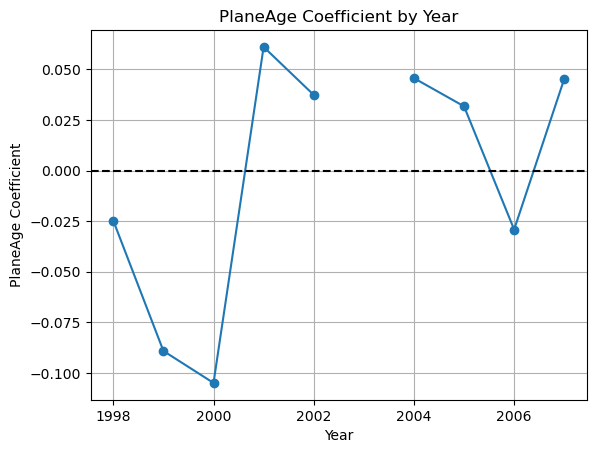

In [107]:
plt.plot(coefficients_df['year'], coefficients_df['coefficient'], marker='o', linestyle='-')
plt.axhline(y=0, linestyle='--', color='black')
plt.xlabel('Year')
plt.ylabel('PlaneAge Coefficient')
plt.title('PlaneAge Coefficient by Year')
plt.xticks(range(1998, 2008, 2))
plt.grid(True)
plt.show()

We created a scatter plot to visualize the relationship between the age of the plane and the total delay. To prevent overlapping of points and provide better visibility of density, we applied jitter to each point. Additionally, we fitted a model to the data, and the blue line in the plot represents the regression line.

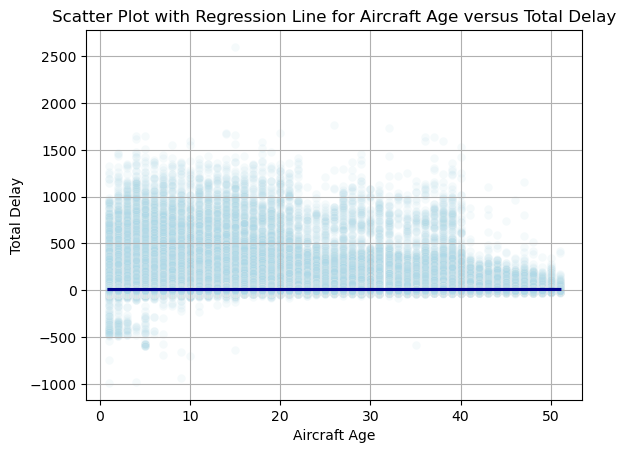

In [108]:
sns.scatterplot(data=flights_subset_2_clean, x='PlaneAge', y='Total_Delay', color='lightblue', alpha=0.12)
sns.regplot(data=flights_subset_2_clean, x='PlaneAge', y='Total_Delay', scatter=False, color='darkblue')
plt.title('Scatter Plot with Regression Line for Aircraft Age versus Total Delay')
plt.xlabel('Aircraft Age')
plt.ylabel('Total Delay')
plt.grid(True)
plt.show()

We read carriers.csv and store it as an object "carriers". When then combine it with "flights_subset_2_clen" dataframe using leftjoin function.

In [109]:
carriers = pd.read_csv("carriers.csv")

flights_subset_2_clean = pd.merge(flights_subset_2_clean, carriers, left_on='UniqueCarrier', right_on='Code', how='left')

Renaming the column for clarity purposes.

In [110]:
flights_subset_2_clean = flights_subset_2_clean.rename(columns={'Description': 'Carrier'})

We also merge and renamed the values for both US Airways and America West Airlines as both companies merged on 9/05.

In [111]:
carrier_mapping = {
    "America West Airlines Inc. (Merged with US Airways 9/05. Stopped reporting 10/07.)": "US Airways Inc.",
    "US Airways Inc. (Merged with America West 9/05. Reporting for both starting 10/07.)": "US Airways Inc."
}

flights_subset_2_clean['Carrier'] = flights_subset_2_clean['Carrier'].replace(carrier_mapping)

Given the strong correlation between Total Delay and carrier-specific delays, as indicated by the Pearson correlation coefficient, we aim to enhance the explanatory capability of our model by including carrier information as a predictor. We will fit the carrier variable into the regression model and evaluate its impact on model performance.

In [112]:
# Fit regression model with formula
model_formula = smf.ols(formula='Total_Delay ~ PlaneAge + C(Carrier)', data=flights_subset_2_clean)
result = model_formula.fit()

# Display model summary
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            Total_Delay   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     5146.
Date:                Sun, 31 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:38:40   Log-Likelihood:            -1.5764e+08
No. Observations:            32144166   AIC:                         3.153e+08
Df Residuals:                32144144   BIC:                         3.153e+08
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [113]:
X = model_formula.exog

# Calculate VIF for each predictor
vif = pd.DataFrame()
vif["Variable"] = model_formula.exog_names
vif["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

print(vif)

                                      Variable        VIF
0                                    Intercept  35.460711
1           C(Carrier)[T.Alaska Airlines Inc.]   1.982113
2            C(Carrier)[T.Aloha Airlines Inc.]   1.076854
3         C(Carrier)[T.American Airlines Inc.]   3.864369
4   C(Carrier)[T.American Eagle Airlines Inc.]   2.591617
5    C(Carrier)[T.Atlantic Southeast Airlines]   2.238115
6                    C(Carrier)[T.Comair Inc.]   2.000892
7     C(Carrier)[T.Continental Air Lines Inc.]   3.421047
8           C(Carrier)[T.Delta Air Lines Inc.]   5.082901
9       C(Carrier)[T.Expressjet Airlines Inc.]   2.856719
10        C(Carrier)[T.Frontier Airlines Inc.]   1.229859
11        C(Carrier)[T.Hawaiian Airlines Inc.]   1.221343
12              C(Carrier)[T.Independence Air]   1.096930
13               C(Carrier)[T.JetBlue Airways]   1.474692
14            C(Carrier)[T.Mesa Airlines Inc.]   1.520179
15       C(Carrier)[T.Northwest Airlines Inc.]   4.247634
16         C(C

### (c)For each year, fit a logistic regression model for the probability of diverted US flights using as many features as possible from attributes of the departure date, the scheduled departure and arrival times, the coordinates and distance between departure and planned arrival airports, and the carrier. Visualize the coefficients across years.

# 4.1 Data Cleaning

In [114]:
flights_subset_3 = df[['Year', 'Month', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime', 'TailNum', 'CRSElapsedTime',
                            'Origin', 'Dest', 'Distance', 'Cancelled', 'Diverted', 'UniqueCarrier']]

print(flights_subset_3.info())
print(flights_subset_3.head())

<class 'pandas.core.frame.DataFrame'>
Index: 63188261 entries, 0 to 63188333
Data columns (total 13 columns):
 #   Column          Dtype   
---  ------          -----   
 0   Year            int64   
 1   Month           category
 2   DayOfWeek       category
 3   CRSDepTime      int64   
 4   CRSArrTime      int64   
 5   TailNum         object  
 6   CRSElapsedTime  float64 
 7   Origin          object  
 8   Dest            object  
 9   Distance        int64   
 10  Cancelled       int64   
 11  Diverted        int64   
 12  UniqueCarrier   object  
dtypes: category(2), float64(1), int64(6), object(4)
memory usage: 7.8+ GB
None
   Year Month DayOfWeek  CRSDepTime  CRSArrTime TailNum  CRSElapsedTime  \
0  1998   Jan       Sat         715         840    N520           145.0   
1  1998   Jan       Sun         715         840    N302           145.0   
2  1998   Jan       Mon         715         840    N315           145.0   
3  1998   Jan       Tue         715         840    N372     

Creating Time Intervals categories for both scheduled departure and arrival time.

In [115]:
flights_subset_3 = create_time_intervals(flights_subset_3, 'CRSDepTime')
flights_subset_3 = flights_subset_3.rename(columns={'Bins': 'DepartureInterval'}) #differentiating Departure and Arrival interval

flights_subset_3 = create_time_intervals(flights_subset_3, 'CRSArrTime')
flights_subset_3 = flights_subset_3.rename(columns={'Bins': 'ArrivalInterval'})

print(flights_subset_3.head())

/var/folders/zs/wlhl2ll167973gq44w3m4c800000gn/T/ipykernel_6174/82446830.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'Bins'] = pd.cut(data[time_col], bins=time_intervals, labels=interval_names, right=False)


   Year Month DayOfWeek  CRSDepTime  CRSArrTime TailNum  CRSElapsedTime  \
0  1998   Jan       Sat         715         840    N520           145.0   
1  1998   Jan       Sun         715         840    N302           145.0   
2  1998   Jan       Mon         715         840    N315           145.0   
3  1998   Jan       Tue         715         840    N372           145.0   
4  1998   Jan       Wed         715         840    N367           145.0   

  Origin Dest  Distance  Cancelled  Diverted UniqueCarrier DepartureInterval  \
0    AUS  PHX       872          0         0            WN         4am - 8am   
1    AUS  PHX       872          0         0            WN         4am - 8am   
2    AUS  PHX       872          0         0            WN         4am - 8am   
3    AUS  PHX       872          0         0            WN         4am - 8am   
4    AUS  PHX       872          0         0            WN         4am - 8am   

  ArrivalInterval  
0      8am - 12pm  
1      8am - 12pm  
2      8

Read airports.csv

In [116]:
airports = pd.read_csv("airports.csv") 
airports  = airports.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

Merging airports with subset 3 using left join with "Origin"/"Dest" and "iata" as key. 

In [117]:
flights_subset_3 = pd.merge(flights_subset_3, airports, how='left', left_on='Origin', right_on='iata')

flights_subset_3.rename(columns={'airport': 'airport_Origin',
                                 'city': 'city_Origin',
                                 'state': 'state_Origin',
                                 'country': 'country_Origin',
                                 'lat': 'lat_Origin',
                                 'long': 'long_Origin'}, inplace=True) # Rename columns

# Left join with airports based on 'Dest' column
flights_subset_3 = pd.merge(flights_subset_3, airports, how='left', left_on='Dest', right_on='iata')

flights_subset_3.rename(columns={'airport': 'airport_Dest',
                                 'city': 'city_Dest',
                                 'state': 'state_Dest',
                                 'country': 'country_Dest',
                                 'lat': 'lat_Dest',
                                 'long': 'long_Dest'}, inplace=True) # Rename columns


print(flights_subset_3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63188261 entries, 0 to 63188260
Data columns (total 29 columns):
 #   Column             Dtype   
---  ------             -----   
 0   Year               int64   
 1   Month              category
 2   DayOfWeek          category
 3   CRSDepTime         int64   
 4   CRSArrTime         int64   
 5   TailNum            object  
 6   CRSElapsedTime     float64 
 7   Origin             object  
 8   Dest               object  
 9   Distance           int64   
 10  Cancelled          int64   
 11  Diverted           int64   
 12  UniqueCarrier      object  
 13  DepartureInterval  category
 14  ArrivalInterval    category
 15  iata_x             object  
 16  airport_Origin     object  
 17  city_Origin        object  
 18  state_Origin       object  
 19  country_Origin     object  
 20  lat_Origin         float64 
 21  long_Origin        float64 
 22  iata_y             object  
 23  airport_Dest       object  
 24  city_Dest          obj

We read carriers.csv and store it as an object "carriers". When then combine it with "flights_subset_3" dataframe using leftjoin function.

In [118]:
carriers = pd.read_csv("carriers.csv")
carriers  = carriers.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
planes = pd.read_csv("plane-data.csv")
planes  = planes.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [119]:
flights_subset_3 = flights_subset_3.merge(carriers, left_on='UniqueCarrier', right_on='Code', how='left')

In [120]:
flights_subset_3.rename(columns={'Description': 'Carrier'}, inplace=True)

print(flights_subset_3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63188261 entries, 0 to 63188260
Data columns (total 31 columns):
 #   Column             Dtype   
---  ------             -----   
 0   Year               int64   
 1   Month              category
 2   DayOfWeek          category
 3   CRSDepTime         int64   
 4   CRSArrTime         int64   
 5   TailNum            object  
 6   CRSElapsedTime     float64 
 7   Origin             object  
 8   Dest               object  
 9   Distance           int64   
 10  Cancelled          int64   
 11  Diverted           int64   
 12  UniqueCarrier      object  
 13  DepartureInterval  category
 14  ArrivalInterval    category
 15  iata_x             object  
 16  airport_Origin     object  
 17  city_Origin        object  
 18  state_Origin       object  
 19  country_Origin     object  
 20  lat_Origin         float64 
 21  long_Origin        float64 
 22  iata_y             object  
 23  airport_Dest       object  
 24  city_Dest          obj

We also merge and renamed the values for both US Airways and America West Airlines as both companies merged on 9/05.

In [121]:
flights_subset_3['Carrier'].replace({
    "America West Airlines Inc. (Merged with US Airways 9/05. Stopped reporting 10/07.)": "US Airways Inc.",
    "US Airways Inc. (Merged with America West 9/05. Reporting for both starting 10/07.)": "US Airways Inc."
}, inplace=True)

Check for missing values. There are missing values in various variables, however these variables are not required for our analysis, hence we remove them from the dataframe.

In [122]:
# Compute sum of missing values for each variable and store it in an object.
missing_counts = flights_subset_3.isnull().sum()

missing_summary = missing_counts.reset_index()

missing_summary.columns = ['variable', 'missing_count']

print(missing_summary)

             variable  missing_count
0                Year              0
1               Month              0
2           DayOfWeek              0
3          CRSDepTime              0
4          CRSArrTime              0
5             TailNum          56400
6      CRSElapsedTime          12646
7              Origin              0
8                Dest              0
9            Distance              0
10          Cancelled              0
11           Diverted              0
12      UniqueCarrier              0
13  DepartureInterval             16
14    ArrivalInterval           1091
15             iata_x              0
16     airport_Origin              0
17        city_Origin          23772
18       state_Origin          23772
19     country_Origin              0
20         lat_Origin              0
21        long_Origin              0
22             iata_y              1
23       airport_Dest              1
24          city_Dest          23761
25         state_Dest          23761
2

One observation in our dataset is missing the destination airport information. Since we couldn't locate this data in our airport database, we will exclude this particular observation from our dataset.

In [123]:
flights_subset_3 = flights_subset_3.drop(columns=['CRSElapsedTime', 'city_Origin', 'state_Origin', 'city_Dest', 'state_Dest'])

In [124]:
flights_subset_3 = flights_subset_3.dropna(subset=['airport_Dest', 'DepartureInterval', 'ArrivalInterval'])

missing_summary = flights_subset_3.isnull().sum().reset_index()
missing_summary.columns = ['variable', 'missing_count']
print(missing_summary)

             variable  missing_count
0                Year              0
1               Month              0
2           DayOfWeek              0
3          CRSDepTime              0
4          CRSArrTime              0
5             TailNum          56400
6              Origin              0
7                Dest              0
8            Distance              0
9           Cancelled              0
10           Diverted              0
11      UniqueCarrier              0
12  DepartureInterval              0
13    ArrivalInterval              0
14             iata_x              0
15     airport_Origin              0
16     country_Origin              0
17         lat_Origin              0
18        long_Origin              0
19             iata_y              0
20       airport_Dest              0
21       country_Dest              0
22           lat_Dest              0
23          long_Dest              0
24               Code              0
25            Carrier              0


We aim to assess whether the likelihood of diverted flights is influenced by factors such as engine type, aircraft type, plane age, or manufacturer. To conduct this analysis, we intend to create a new subset, anticipating that this process may result in the removal of numerous observations, as observed in our previous analysis in part (b).

In [125]:
flights_subset_4 = flights_subset_3.merge(planes, how='left', left_on='TailNum', right_on='tailnum')

In [126]:
flights_subset_4.loc[:, 'issue_date'] = pd.to_datetime(flights_subset_4['issue_date'], format='%m/%d/%Y')

In [127]:
missing_summary = flights_subset_4.isnull().sum().reset_index()
missing_summary.columns = ['variable', 'missing_count']
print(missing_summary)

             variable  missing_count
0                Year              0
1               Month              0
2           DayOfWeek              0
3          CRSDepTime              0
4          CRSArrTime              0
5             TailNum          56400
6              Origin              0
7                Dest              0
8            Distance              0
9           Cancelled              0
10           Diverted              0
11      UniqueCarrier              0
12  DepartureInterval              0
13    ArrivalInterval              0
14             iata_x              0
15     airport_Origin              0
16     country_Origin              0
17         lat_Origin              0
18        long_Origin              0
19             iata_y              0
20       airport_Dest              0
21       country_Dest              0
22           lat_Dest              0
23          long_Dest              0
24               Code              0
25            Carrier              0
2

The left join operation is unable to locate the key for some observations, and there are no alternative means to retrieve the information. Hence, we will remove the missing values from our dataframe.

In [128]:
flights_subset_4 = flights_subset_4.dropna(subset=['tailnum', 'type', 'manufacturer', 'issue_date', 'model', 'status', 'aircraft_type', 'engine_type'])

We will utilize the issue_date variable to handle missing values in the "year" variable.

In [129]:
flights_subset_4.loc[:, 'year'] = flights_subset_4.apply(lambda row: row['issue_date'].year if pd.isnull(row['year']) else row['year'], axis=1)

In [130]:
flights_subset_2_NA_omit.loc[:, 'year'] = flights_subset_2_NA_omit.apply(lambda row: row['issue_date'].year if row['year'] == 0 else row['year'], axis=1)

In [131]:
#In this operation we drop NAs in 'year' and convert it to int datatype
flights_subset_4 = flights_subset_4.dropna(subset=['year'])
flights_subset_4.loc[:, 'year'] = flights_subset_4['year'].astype(int)

In [132]:
flights_subset_4['PlaneAge'] = flights_subset_4['Year'] - flights_subset_4['year']

In [133]:
flights_subset_4 = flights_subset_4[(flights_subset_4['PlaneAge'] > 0) & (flights_subset_4['PlaneAge'] < 53)]

# 4.2 Data Exploration

Upon exploring the distribution of variables in our dataframe, we've observed that the frequency of diverted flights is relatively low. Additionally, variables such as engine type, aircraft type, and manufacturer exhibit a large number of groups. To manage this, we intend to aggregate these groups into smaller, more manageable categories.

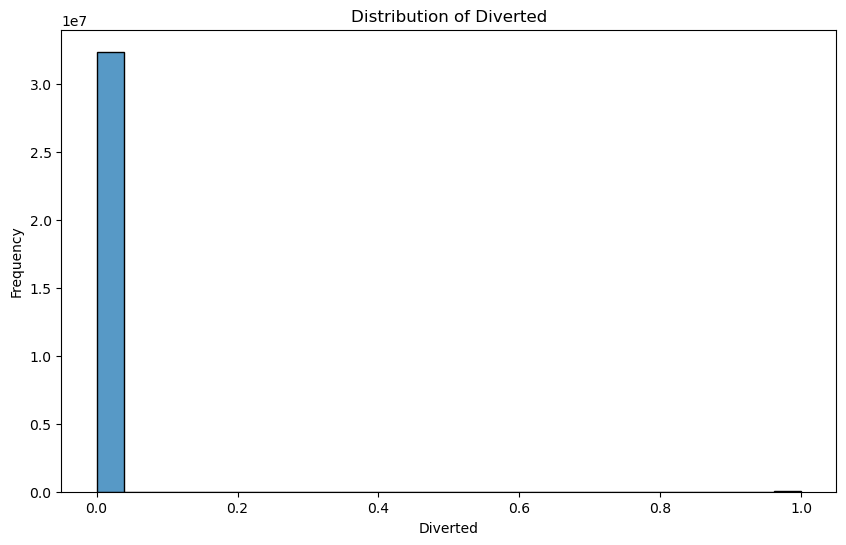

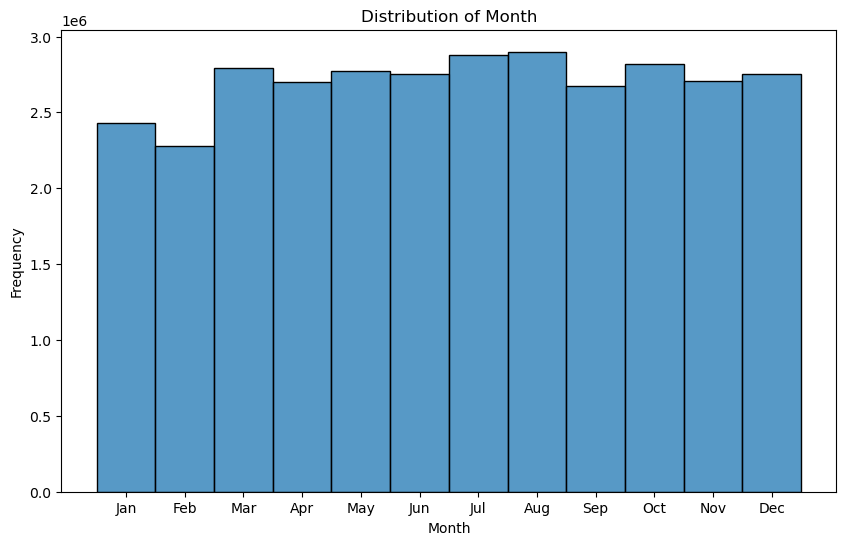

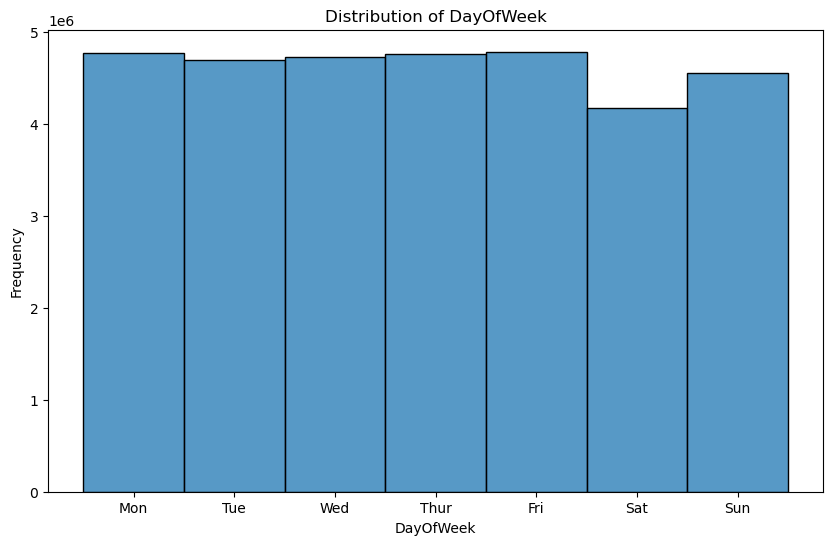

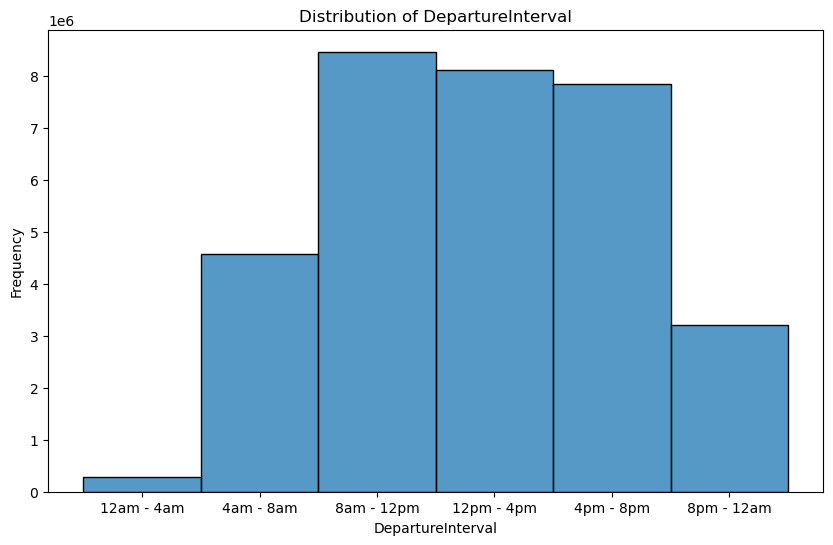

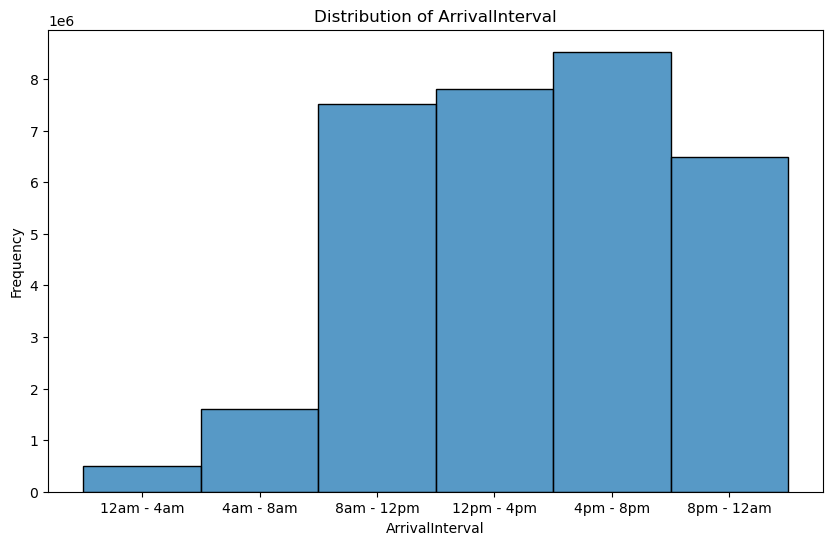

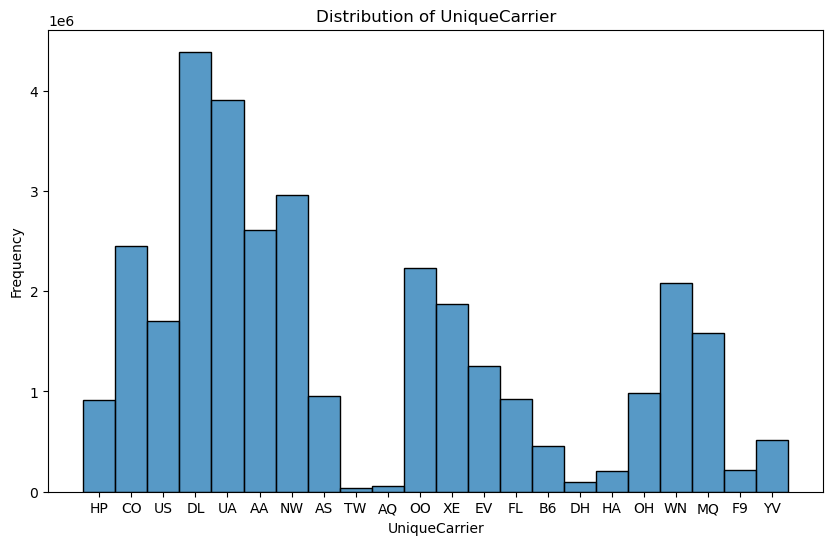

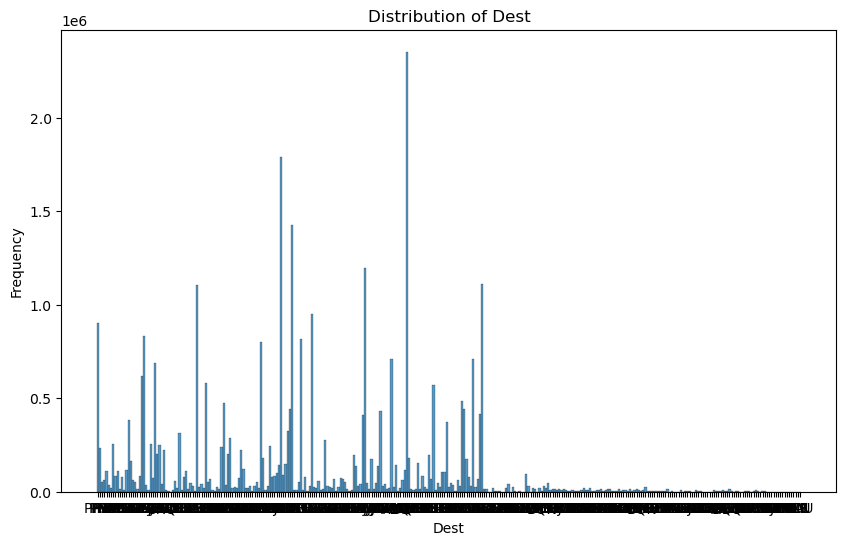

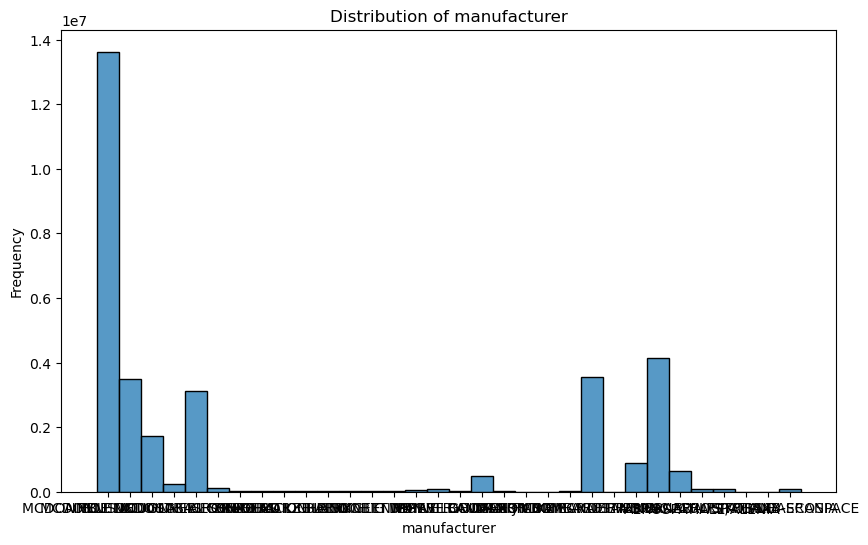

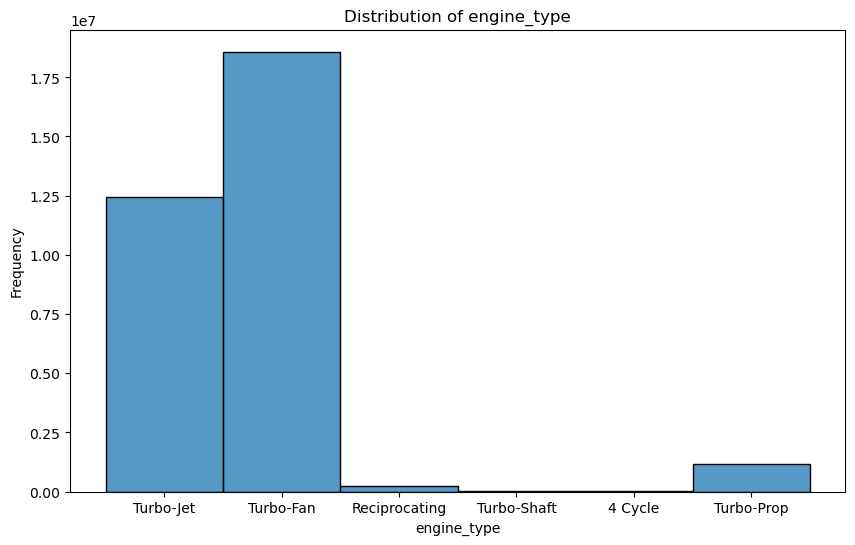

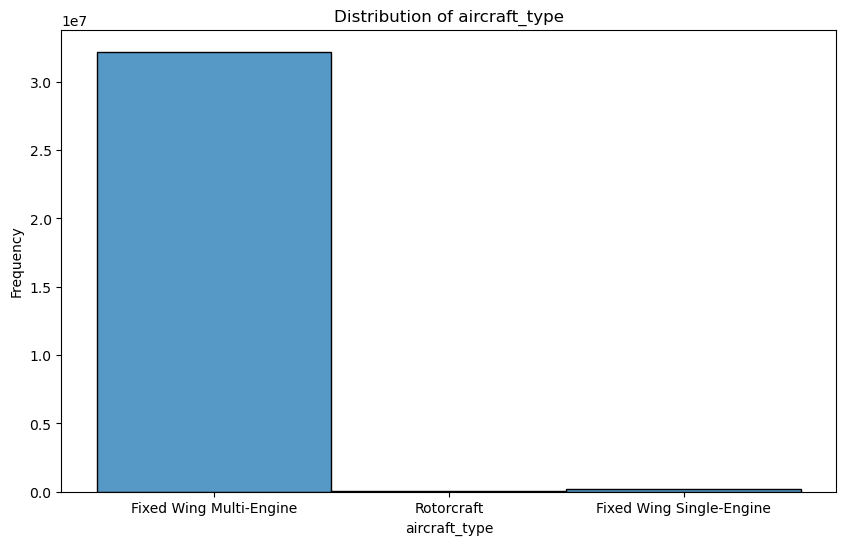

In [134]:
explore_distribution(flights_subset_4, ["Diverted", "Month", "DayOfWeek", "DepartureInterval", "ArrivalInterval", "UniqueCarrier", "Dest", "manufacturer", "engine_type", "aircraft_type"])

In [135]:
replacement_dict = {
    "BOEING": "Boeing",
    "AIRBUS INDUSTRIE": "Airbus",
    "AIRBUS": "Airbus",
    "MCDONNELL DOUGLAS AIRCRAFT CO": "Mcdonnell",
    "MCDONNELL DOUGLAS CORPORATION": "Mcdonnell",
    "MCDONNELL DOUGLAS": "Mcdonnell",
    "BOMBARDIER INC": "Bombardier",
    "EMBRAER": "Embraer"
}

choices = ["Boeing", "Airbus", "Mcdonnell", "Bombardier", "Embraer"]

flights_subset_4['manufacturer'] = flights_subset_4['manufacturer'].map(lambda x: replacement_dict.get(x, "Others"))

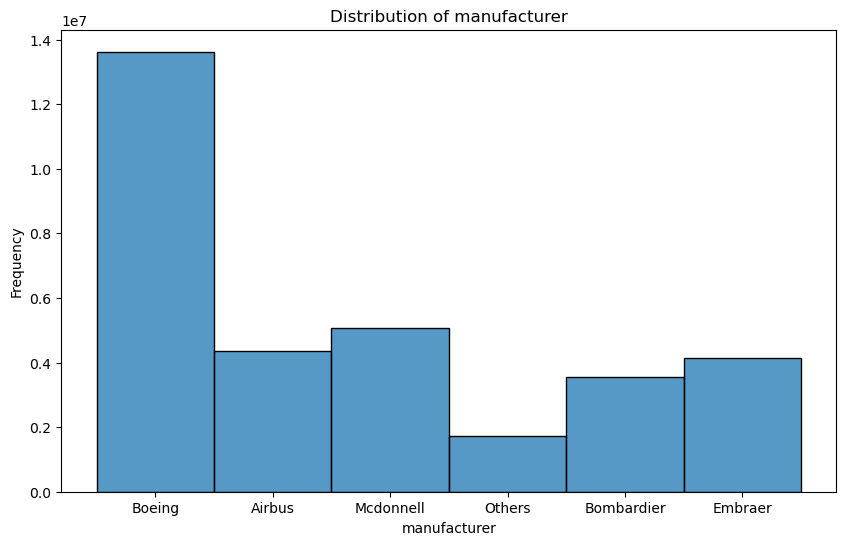

In [136]:
explore_distribution(flights_subset_4, ["manufacturer"])

In [137]:
flights_subset_4.loc[:, 'engine_type'] = flights_subset_4['engine_type'].apply(lambda x: x if x in ["Turbo-Jet", "Turbo-Fan", "Turbo-Prop"] else "Others")

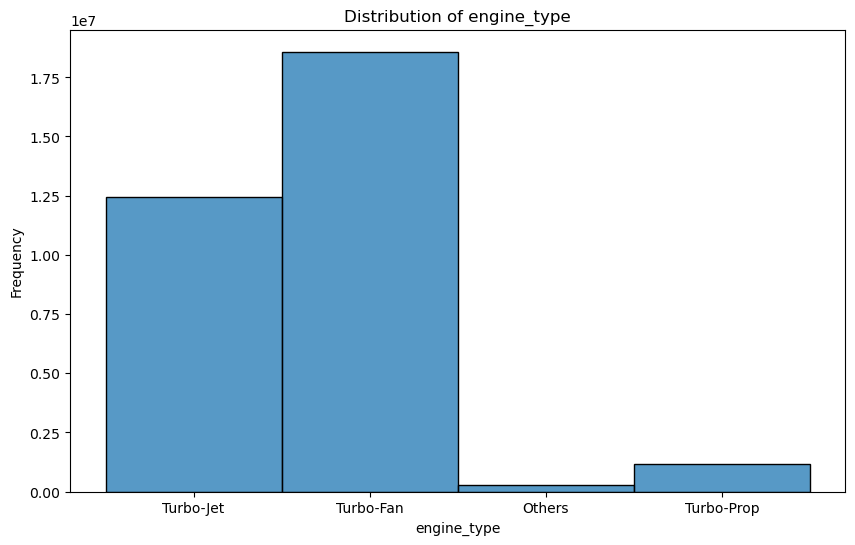

In [138]:
explore_distribution(flights_subset_4, ["engine_type"])

In [139]:
flights_subset_4.loc[:, 'aircraft_type'] = flights_subset_4['aircraft_type'].apply(lambda x: x if x == "Fixed Wing Multi-Engine" else "Others")

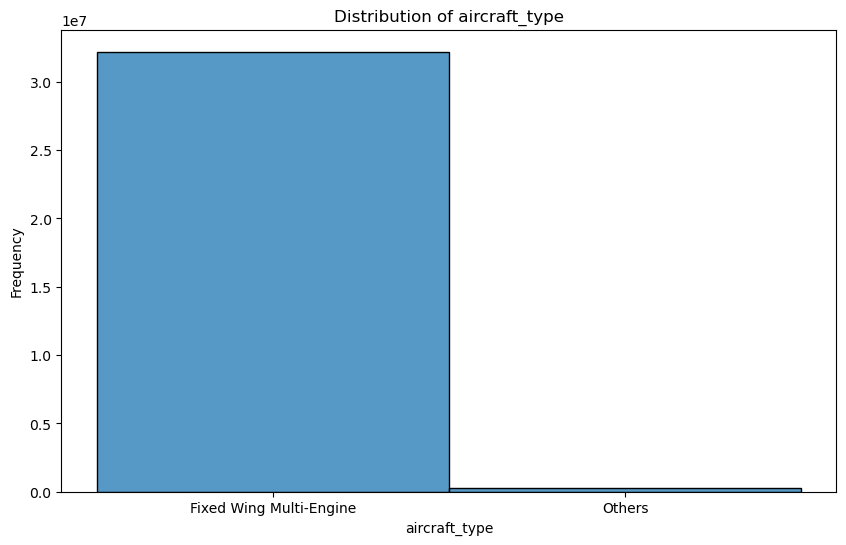

In [140]:
explore_distribution(flights_subset_4, ["aircraft_type"])

Checking for outliers for "Distance" variable.

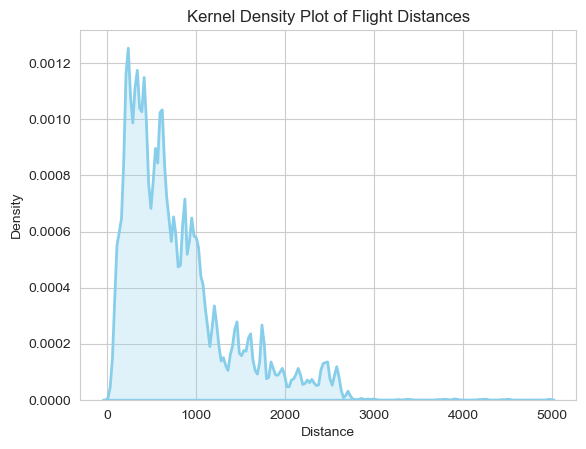

In [141]:
sns.set_style("whitegrid")

sns.kdeplot(data=flights_subset_4, x='Distance', fill=True, color='skyblue', linewidth=2)

plt.title('Kernel Density Plot of Flight Distances')
plt.xlabel('Distance')
plt.ylabel('Density')

plt.show()

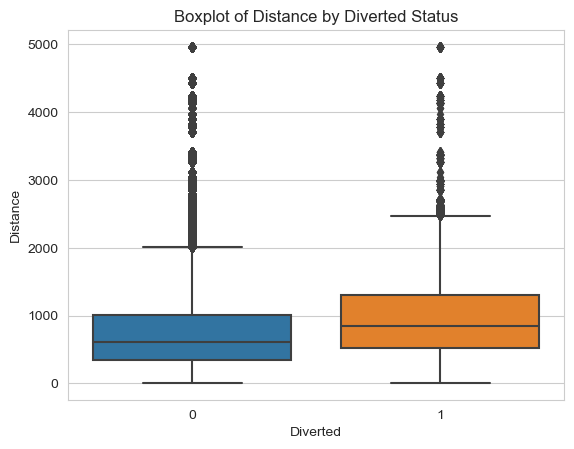

In [142]:
sns.boxplot(data=flights_subset_4, x='Diverted', y='Distance')
plt.title('Boxplot of Distance by Diverted Status')
plt.xlabel('Diverted')
plt.ylabel('Distance')
plt.show()

We compute the maximum to detemine a cutoff point beyond which data points are considered outliers.

In [143]:
Q3 = np.quantile(flights_subset_4['Distance'], q=0.75)
Q1 = np.quantile(flights_subset_4['Distance'], q=0.25)
IQR = Q3 - Q1

# Calculate the upper bound for outliers
maximum = Q3 + 1.5 * IQR

print(maximum)

2014.5


We have detected 3,289,407 outliers in our dataset. Considering that these outlier values are not excessively extreme and appear to be genuine data points rather than resulting from data entry errors, we have decided to retain these values. Additionally, since our sample size is large, these outliers are less likely to significantly influence our overall analysis.

In [144]:
flights_subset_4[flights_subset_4['Distance'] > 1930].shape[0]

2012215

We generate a contingency table to ensure we have enough diverted samples for each year.

In [145]:
cross_tab = pd.crosstab(flights_subset_4['Year'], flights_subset_4['Diverted'])

print(cross_tab)

Diverted        0      1
Year                    
1998      1763554   4340
1999      1957555   4661
2000      2129351   5178
2001       242028    534
2002      1954014   3342
2003      3239760   5896
2004      4371988   8691
2005      4937646  10128
2006      5396464  12775
2007      6389594  14525


Checking the data type of each variables.

In [146]:
flights_subset_4.dtypes

Year                    int64
Month                category
DayOfWeek            category
CRSDepTime              int64
CRSArrTime              int64
TailNum                object
Origin                 object
Dest                   object
Distance                int64
Cancelled               int64
Diverted                int64
UniqueCarrier          object
DepartureInterval    category
ArrivalInterval      category
iata_x                 object
airport_Origin         object
country_Origin         object
lat_Origin            float64
long_Origin           float64
iata_y                 object
airport_Dest           object
country_Dest           object
lat_Dest              float64
long_Dest             float64
Code                   object
Carrier                object
tailnum                object
type                   object
manufacturer           object
issue_date             object
model                  object
status                 object
aircraft_type          object
engine_typ

Converting categorical variables we will be using to fit our logistic regression to factors. Reference will be selected based on the group with highest frequency. For time interval, month and day of week, reference will be "12am - 4am", Jan and Monday respectively. This will enhance the interpretation of the model summary.

In [147]:
# Convert Carrier variable to categorical
flights_subset_3['Carrier'] = pd.Categorical(flights_subset_3['Carrier'])

# We set reference for Southwest Airlines by reordering it to the beginning, followed by the rest of the categories.
flights_subset_3.loc[:, 'Carrier'] = flights_subset_3['Carrier'].cat.set_categories(['Southwest Airlines Co.', *flights_subset_3['Carrier'].cat.categories.difference(['Southwest Airlines Co.'])])

In [148]:
# Convert Carrier variable to categorical
flights_subset_4['Carrier'] = pd.Categorical(flights_subset_4['Carrier'])

flights_subset_4.loc[:, 'Carrier'] = flights_subset_4['Carrier'].cat.set_categories(['Southwest Airlines Co.', *flights_subset_4['Carrier'].cat.categories.difference(['Southwest Airlines Co.'])])

# Convert aircraft type variable to categorical
flights_subset_4['aircraft_type'] = pd.Categorical(flights_subset_4['aircraft_type'])

flights_subset_4.loc[:, 'aircraft_type'] = flights_subset_4['aircraft_type'].cat.set_categories(['Fixed Wing Multi-Engine', *flights_subset_4['aircraft_type'].cat.categories.difference(['Fixed Wing Multi-Engine'])])

# Convert engine type variable to categorical
flights_subset_4['engine_type'] = pd.Categorical(flights_subset_4['engine_type'])

flights_subset_4.loc[:, 'engine_type'] = flights_subset_4['engine_type'].cat.set_categories(['Turbo-Fan', *flights_subset_4['engine_type'].cat.categories.difference(['Turbo-Fan'])])

# Convert manufacturer variable to categorical
flights_subset_4['manufacturer'] = pd.Categorical(flights_subset_4['manufacturer'])

flights_subset_4.loc[:, 'manufacturer'] = flights_subset_4['manufacturer'].cat.set_categories(['Boeing', *flights_subset_4['manufacturer'].cat.categories.difference(['Boeing'])])

flights_subset_4.loc[:, 'Diverted'] = flights_subset_4['Diverted'].astype('category').cat.rename_categories({0: 'Not Diverted', 1: 'Diverted'})


flights_subset_4.dtypes

Year                    int64
Month                category
DayOfWeek            category
CRSDepTime              int64
CRSArrTime              int64
TailNum                object
Origin                 object
Dest                   object
Distance                int64
Cancelled               int64
Diverted             category
UniqueCarrier          object
DepartureInterval    category
ArrivalInterval      category
iata_x                 object
airport_Origin         object
country_Origin         object
lat_Origin            float64
long_Origin           float64
iata_y                 object
airport_Dest           object
country_Dest           object
lat_Dest              float64
long_Dest             float64
Code                   object
Carrier              category
tailnum                object
type                   object
manufacturer         category
issue_date             object
model                  object
status                 object
aircraft_type        category
engine_typ

Selecting the required variables for our model.

In [149]:
flights_subset_4 = flights_subset_4[['Distance', 'DepartureInterval', 'ArrivalInterval', 'Month', 'DayOfWeek', 'Carrier', 'lat_Origin', 'long_Origin', 'lat_Dest', 'long_Dest', 'Year', 'Diverted', 'engine_type', 'aircraft_type', 'manufacturer', 'PlaneAge']]

# 4.3 Feature Selection

Given the extensive size of our dataset, we opt to work with a smaller sample size for model training and testing purposes. Selecting just 5% of the total population not only ensures meaningful results but also significantly improves programming efficiency by reducing processing time.

In [150]:
# Defining subsample proportion
subsample_proportion = 0.2
num_subsample = round(len(flights_subset_4) * subsample_proportion)

# Perform random subsampling
np.random.seed(2222)
subsample_indices = np.random.choice(flights_subset_4.index, num_subsample, replace=False)
flights_subset_4_subsample = flights_subset_4.loc[subsample_indices]

# Convert Diverted to factors
flights_subset_4_subsample['Diverted'] = np.where(flights_subset_4_subsample['Diverted'] == 0, 'Not.Diverted', 'Diverted')
flights_subset_4_subsample['Diverted'] = flights_subset_4_subsample['Diverted'].astype('category')

We further split the data into training and testing set.

In [151]:
np.random.seed(4444)

# Split data into training and testing sets, stratifying by diverted to ensure there are the same proportion of diverted observations for both training and testing set.
train_data, test_data = train_test_split(flights_subset_4_subsample, test_size=0.3, stratify=flights_subset_4_subsample['Diverted'])

We perform a quick logistic model summary all the variables.

In [152]:
flights_subset_4.dtypes

Distance                int64
DepartureInterval    category
ArrivalInterval      category
Month                category
DayOfWeek            category
Carrier              category
lat_Origin            float64
long_Origin           float64
lat_Dest              float64
long_Dest             float64
Year                    int64
Diverted             category
engine_type          category
aircraft_type        category
manufacturer         category
PlaneAge              float64
dtype: object

In [153]:
formula = 'Diverted ~ Distance + DepartureInterval + ArrivalInterval + Month + DayOfWeek + Carrier + lat_Origin + long_Origin + lat_Dest + long_Dest + Year + engine_type + aircraft_type + manufacturer + PlaneAge'

# Fit the logistic regression model
logit_model = smf.logit(formula=formula, data=train_data)
model = logit_model.fit()

print(model.summary())

/Users/felix/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/felix/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/felix/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/felix/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparat

         Current function value: 0.000000
         Iterations: 35


/Users/felix/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/felix/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/felix/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/felix/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/

                           Logit Regression Results                           
Dep. Variable:     Diverted[Diverted]   No. Observations:              4543283
Model:                          Logit   Df Residuals:                  4543219
Method:                           MLE   Df Model:                           63
Date:                Sun, 31 Mar 2024   Pseudo R-squ.:                     inf
Time:                        21:57:24   Log-Likelihood:            -1.0279e-09
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  14.9668   2.85e+07   5.25e-07      1.000   -5.59e+07    5.59e+07
DepartureInterval[T.4am - 8am]             -

/Users/felix/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/felix/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:4465: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.llf/self.llnull


Upon assessing multicollinearity, it's evident that high VIF values are observed for the Departure Interval and Arrival Interval variables. Consequently, we will exclude the Arrival Interval variable from our model, given that diverted flights are primarily associated with departure-related factors.

In addition, high VIF values are also observed for engine_type, manufacturer, aircraft_type, PlaneAge and Carrier. We will carry out Chi-Square Test, Cramera_V and Anova to determine if there's any association between the variables.

In [154]:
X = model.model.exog
exog_names = model.model.exog_names

# Calculate VIF for each predictor
vif = pd.DataFrame()
vif["Variable"] = exog_names
vif["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

print(vif)

                           Variable            VIF
0                         Intercept  844516.826574
1    DepartureInterval[T.4am - 8am]      19.810106
2   DepartureInterval[T.8am - 12pm]      31.878804
3   DepartureInterval[T.12pm - 4pm]      31.040927
4    DepartureInterval[T.4pm - 8pm]      30.241160
..                              ...            ...
59                      long_Origin       1.929500
60                         lat_Dest       1.299647
61                        long_Dest       1.905010
62                             Year       1.581300
63                         PlaneAge       3.150040

[64 rows x 2 columns]


In [155]:
chi_sq_test = chi2_contingency(pd.crosstab(flights_subset_4_subsample['Carrier'], flights_subset_4_subsample['aircraft_type']))
print("Chi-square test:")
print(chi_sq_test)

Chi-square test:
Chi2ContingencyResult(statistic=428188.7391286858, pvalue=0.0, dof=20, expected_freq=array([[1.84862511e+05, 1.32748916e+03],
       [1.89262912e+05, 1.35908823e+03],
       [1.21656391e+04, 8.73608927e+01],
       [5.18157138e+05, 3.72086248e+03],
       [3.14762704e+05, 2.26029644e+03],
       [2.49815089e+05, 1.79391062e+03],
       [1.96675681e+05, 1.41231898e+03],
       [4.88374009e+05, 3.50699121e+03],
       [8.71647738e+05, 6.25926216e+03],
       [3.72198261e+05, 2.67273853e+03],
       [4.37140911e+04, 3.13908870e+02],
       [4.19825254e+04, 3.01474577e+02],
       [1.87374473e+04, 1.34552744e+02],
       [9.09161354e+04, 6.52864571e+02],
       [1.02180248e+05, 7.33751646e+02],
       [5.87865565e+05, 4.22143548e+03],
       [4.42307808e+05, 3.17619195e+03],
       [4.14024906e+05, 2.97309374e+03],
       [8.22890859e+03, 5.90914126e+01],
       [5.19807288e+05, 3.73271213e+03],
       [7.76443396e+05, 5.57560418e+03]]))


In [156]:
chi_sq_test = chi2_contingency(pd.crosstab(flights_subset_4_subsample['Carrier'], flights_subset_4_subsample['engine_type']))
print("Chi-square test:")
print(chi_sq_test)

Chi-square test:
Chi2ContingencyResult(statistic=4007828.5892500756, pvalue=0.0, dof=60, expected_freq=array([[1.54852220e+03, 1.06649001e+05, 7.12973125e+04, 6.69516394e+03],
       [1.58538266e+03, 1.09187636e+05, 7.29944482e+04, 6.85453322e+03],
       [1.01906883e+02, 7.01847690e+03, 4.69201337e+03, 4.40602845e+02],
       [4.34040317e+03, 2.98929951e+05, 1.99841554e+05, 1.87660925e+04],
       [2.63664618e+03, 1.81589701e+05, 1.21396895e+05, 1.13997581e+04],
       [2.09260498e+03, 1.44120783e+05, 9.63480611e+04, 9.04755091e+03],
       [1.64747658e+03, 1.13464135e+05, 7.58533865e+04, 7.12300142e+03],
       [4.09092135e+03, 2.81747771e+05, 1.88354871e+05, 1.76874372e+04],
       [7.30145805e+03, 5.02862156e+05, 3.36174927e+05, 3.15684585e+04],
       [3.11776177e+03, 2.14724839e+05, 1.43548498e+05, 1.34799012e+04],
       [3.66176138e+02, 2.52190893e+04, 1.68595417e+04, 1.58319286e+03],
       [3.51671478e+02, 2.42201320e+04, 1.61917158e+04, 1.52048076e+03],
       [1.56956393e+0

In [157]:
chi_sq_test = chi2_contingency(pd.crosstab(flights_subset_4_subsample['Carrier'], flights_subset_4_subsample['manufacturer']))
print("Chi-square test:")
print(chi_sq_test)

Chi-square test:
Chi2ContingencyResult(statistic=15760882.273786033, pvalue=0.0, dof=100, expected_freq=array([[ 25015.71913617,  78175.18371812,  20325.14270681,
         23708.22479337,  29069.73188422,   9895.99776131],
       [ 25611.18434489,  80036.03776097,  20808.95511605,
         24272.56687556,  29761.69735879,  10131.55854373],
       [  1646.26245542,   5144.64002416,   1337.57974965,
          1560.21740369,   1913.05346569,    651.24690139],
       [ 70117.37188542, 219119.76222377,  56970.00282263,
         66452.55351369,  81480.49592498,  27737.8136295 ],
       [ 42593.90046569, 133107.74621553,  34607.32432645,
         40367.64889988,  49496.60890022,  16849.77119224],
       [ 33805.1456906 , 105642.5146363 ,  27466.50642525,
         32038.25518038,  39283.5607157 ,  13373.01735177],
       [ 26614.28525832,  83170.77067702,  21623.9694318 ,
         25223.23880374,  30927.35941501,  10528.37641411],
       [ 66087.09890122, 206524.98814358,  53695.42682082,
    

In [158]:
model = ols('PlaneAge ~ C(Carrier)', data=flights_subset_4_subsample).fit()

anova_result = sm.stats.anova_lm(model, typ=2)

print(anova_result)

                  sum_sq         df              F  PR(>F)
C(Carrier)  1.161883e+08       20.0  171719.150355     0.0
Residual    2.195756e+08  6490384.0            NaN     NaN


Since correlation is observed between Carrier and various variables associated with aircraft information, we will remove them and retain only Carrier Variable. 

In [159]:
flights_subset_4_subsample.drop(columns=['manufacturer', 'engine_type', 'aircraft_type', 'Year', 'ArrivalInterval', 'PlaneAge'], inplace=True)

During the merging process of the flights and aircraft dataframes, we encountered missing information in the aircraft data, resulting in the omission of several entries with NA values. To address this, we will revert to using the original dataframe before the merge operation.

In [161]:
flights_subset_3 = flights_subset_3[["Distance", "DepartureInterval", "Month", "DayOfWeek", "Carrier", "lat_Origin", "long_Origin", "lat_Dest", "long_Dest", "Diverted", "Year"]]

In [162]:
predictors = ["Distance", "DepartureInterval", "Month", "DayOfWeek", "Carrier", "lat_Origin", "long_Origin", "lat_Dest", "long_Dest"]

We extract samples from the subset to enhance the processing speed.

In [163]:
# Defining subsample proportion
subsample_proportion = 0.05
num_subsample = round(len(flights_subset_3) * subsample_proportion)

# Perform random subsampling
np.random.seed(2222)
subsample_indices = np.random.choice(flights_subset_3.index, num_subsample, replace=False)
flights_subset_3_subsample = flights_subset_3.loc[subsample_indices]

Before training our logistic regression model, we will split the data into training and testing set 

In [164]:
train_data, test_data = train_test_split(flights_subset_3_subsample, test_size=0.3, random_state=42)

We will create a function that allows us to build multiple models using a single predictor each to evaluate its capability in classifying and predicting flight diversions. Since the 'diverted' variable is imbalanced, we'll measure the Area Under the Curve (AUC) value instead of accuracy to gauge performance accurately. The function will return a dataframe containing the AUC results of each model. Cross validation is performed on the training data and the mean AUC of each iteration will be computed.

In [165]:
def fit_logistic_model_single_variable(data, predictors, target, n_folds=4):
    auc_values = []
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    for predictor in predictors:
        if predictor in data.columns:
            X = data[[predictor]]
            if data[predictor].dtype == 'category':
                X = pd.get_dummies(X, drop_first=True)
            y = data[target]

            model = LogisticRegression(max_iter=10000)
            cv_auc = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')
            auc_values.append(np.mean(cv_auc))
        else:
            print(f"Predictor '{predictor}' not found in the dataset.")

    auc_df = pd.DataFrame({'Predictor': predictors, 'AUC': auc_values})
    return auc_df

We initialise an object containing all the predictors that we have selected to train the model. Subsequently, we call the function and input the arguments required to generate the dataframe containing the AUC results.

In [166]:
predictors = ['Distance', 'DepartureInterval', 'Month', 'DayOfWeek', 'Carrier',
              'lat_Origin', 'long_Origin', 'lat_Dest', 'long_Dest']

auc_df = fit_logistic_model_single_variable(train_data, predictors, 'Diverted', n_folds=4)
print(auc_df)

           Predictor       AUC
0           Distance  0.616197
1  DepartureInterval  0.519844
2              Month  0.563552
3          DayOfWeek  0.501432
4            Carrier  0.567261
5         lat_Origin  0.505226
6        long_Origin  0.524757
7           lat_Dest  0.508137
8          long_Dest  0.524051


Additionally, we'll create another function that iterates through each predictor, removes them one by one from the full model containing all predictors, and evaluates how much the AUC decreases when each predictor is excluded. Each model will contain all the predictors except for the predictor selected to be excluded.

In [167]:
def fit_logistic_model_leave_one_out(data, predictors, target, n_folds=4):
    auc_values = []
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    for excluded_predictor in predictors:
        included_predictors = [p for p in predictors if p != excluded_predictor]
        
        X = data[included_predictors]
        if any(data[p].dtype == 'category' for p in included_predictors):
            X = pd.get_dummies(X, drop_first=True)
        y = data[target]

        model = LogisticRegression(max_iter=10000)
        cv_auc = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')
        auc_values.append(np.mean(cv_auc))

    auc_df = pd.DataFrame({'Excluded_Predictor': predictors, 'AUC': auc_values})
    return auc_df


In [168]:
auc_df_2 = fit_logistic_model_leave_one_out(train_data, predictors, 'Diverted', n_folds=4)
print(auc_df_2)

  Excluded_Predictor       AUC
0           Distance  0.593094
1  DepartureInterval  0.628423
2              Month  0.611736
3          DayOfWeek  0.630019
4            Carrier  0.623845
5         lat_Origin  0.627220
6        long_Origin  0.630516
7           lat_Dest  0.629931
8          long_Dest  0.628630


We fit a log reg model that includes all variables to determine the full_model AUC.

In [169]:
predictors = ["Distance", "DepartureInterval", "Month", "DayOfWeek", "Carrier", "lat_Origin", "long_Origin", "lat_Dest", "long_Dest"]
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
X = train_data[predictors]
if any(X[col].dtype == 'category' for col in X.columns):
    X = pd.get_dummies(X, drop_first=True)
y = train_data['Diverted']

model = LogisticRegression(max_iter=10000)
full_model_cv_auc = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')

In [170]:
mean_auc_full_model = full_model_cv_auc.mean()

print("Full Model Mean AUC score:", mean_auc_full_model)

Full Model Mean AUC score: 0.6350650647774523


Variables that do not have much explanatory power are removed. A log reg model will be fitted on the remaining variables to compute the AUC score.

In [171]:
partial_model_predictors = ["Distance", "Month", "Carrier", "long_Origin", "long_Dest"]

X = train_data[partial_model_predictors]
if any(X[col].dtype == 'category' for col in X.columns):
    X = pd.get_dummies(X, drop_first=True)
y = train_data['Diverted']

model = LogisticRegression()
partial_model_cv_auc = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')

/Users/felix/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/felix/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

In [172]:
mean_auc_partial_model = partial_model_cv_auc.mean()

print("Partial Model Mean AUC score:", mean_auc_partial_model)

Partial Model Mean AUC score: 0.6309176584958056


We remove lat_Dest, lat_Origin, DayOfWeek and Departure Interval from our model.

In [173]:
flights_subset_3_subsample = flights_subset_3_subsample.drop(columns = ['lat_Dest', 'lat_Origin', 'DayOfWeek', 'DepartureInterval'])

We split the data into training and testing data set

In [174]:
X = flights_subset_3_subsample.drop(columns = ['Diverted'])
y = flights_subset_3_subsample['Diverted']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Defining Categorical and Numeric predictors

In [175]:
predictors = ['Distance', 'Month', 'Carrier', 'long_Origin', 'long_Dest']

categorical_predictors = ["Month", "Carrier"]  
numeric_predictors = [col for col in predictors if col not in categorical_predictors]

Creating a learner to train the log reg model.

In [178]:
# Define the pipeline transformers for numeric and categorical features
numeric_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),  # Impute missing values with median
    ('scaler', StandardScaler())  # Scale numeric features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with most frequent value
    ('onehot', OneHotEncoder(drop='first'))  # One-hot encode categorical features
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_predictors),
        ('cat', categorical_transformer, categorical_predictors)
    ])

# Create a pipeline with preprocessing and logistic regression
pipe_logistic = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('logistic', LogisticRegression(max_iter = 10000))
])

# Define grid search parameters
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
    'logistic__C': [0.1, 1, 10, 100, 1000, 10000]
}

# Perform grid search
grid_search = GridSearchCV(pipe_logistic, param_grid, cv = 4, scoring = 'roc_auc')

In [179]:
grid_search.fit(x_train, y_train)

#Printing the best parameter and best grid score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'logistic__C': 10000, 'preprocessor__cat__imputer__strategy': 'most_frequent', 'preprocessor__num__imputer__strategy': 'mean'}
Best score: 0.6396462210299335


In [180]:
final_model = pipe_logistic.fit(x_train, y_train)

# Predict probabilities for the test set
y_pred_proba = final_model.predict_proba(x_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

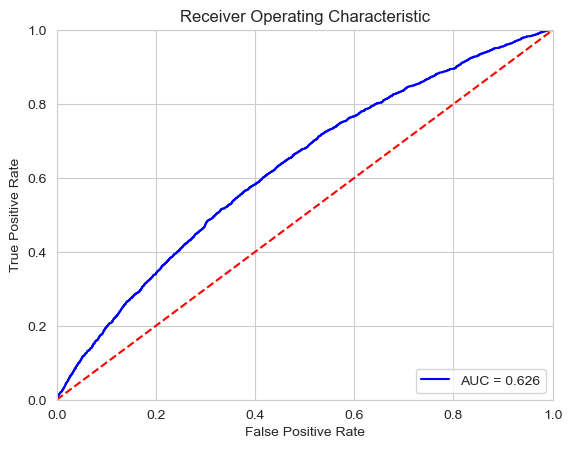

In [181]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

We conduct a sensitive analysis to visualize the trade-off between sensitivity and specificity.

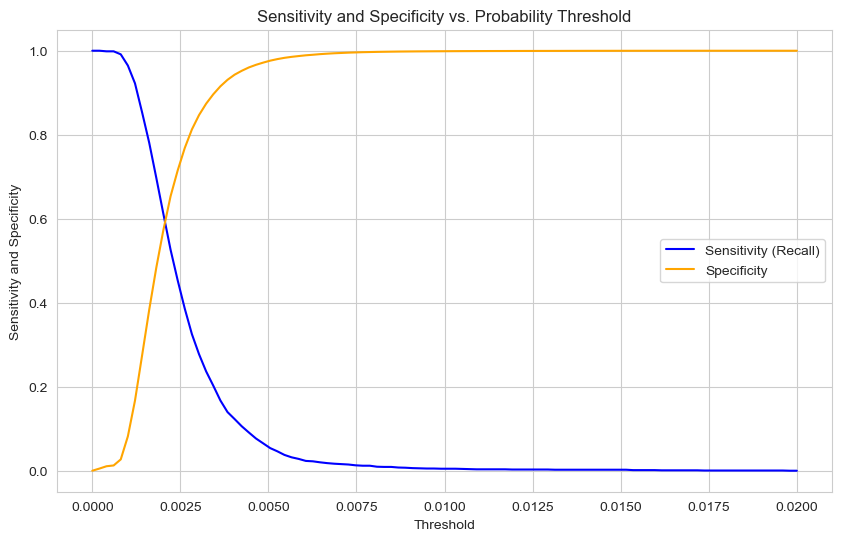

In [183]:
y_pred_proba = y_pred_proba

# Define a list of threshold values
threshold_values = np.linspace(0, 0.02, num=100)

# Initialize lists to store sensitivity and specificity values
sensitivities = []
specificities = []

# Calculate sensitivity and specificity for each threshold value
for threshold in threshold_values:
    # Convert probabilities to binary predictions based on the threshold
    y_pred_binary = np.where(y_pred_proba >= threshold, 1, 0)
    
    # Calculate true positives, true negatives, false positives, and false negatives
    TP = np.sum((y_test == 1) & (y_pred_binary == 1))
    TN = np.sum((y_test == 0) & (y_pred_binary == 0))
    FP = np.sum((y_test == 0) & (y_pred_binary == 1))
    FN = np.sum((y_test == 1) & (y_pred_binary == 0))
    
    # Calculate sensitivity and specificity
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    
    # Append sensitivity and specificity to lists
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Plot sensitivity and specificity vs. threshold
plt.figure(figsize=(10, 6))
plt.plot(threshold_values, sensitivities, label='Sensitivity (Recall)', color='blue')
plt.plot(threshold_values, specificities, label='Specificity', color='orange')
plt.xlabel('Threshold')
plt.ylabel('Sensitivity and Specificity')
plt.title('Sensitivity and Specificity vs. Probability Threshold')
plt.legend()
plt.grid(True)
plt.show()

# 4.4 Visualising the Coefficient across years

We aim to visualise the coefficients of different variables across different years. To achieve this, we wil iterate through each yearly data subset, fitting a logistic regression model to extract the coefficients and storing it in a dataframe.

In [184]:
coefficients_list = []
years_list = []
feature_names_list = []

# Loop through each year
for year in range(1998, 2008):
    # Filter data for the current year
    subset_data = train_data[train_data['Year'] == year]
    
    # Define predictors and target for the current year
    X_year = subset_data.drop(columns=['Diverted'])
    y_year = subset_data['Diverted']
    
    # Split data into train and test sets
    x_train_year, x_test_year, y_train_year, y_test_year = train_test_split(X_year, y_year, test_size=0.3, random_state=42)
    
    # Fit the model for the current year using GridSearchCV
    pipe_logistic.fit(x_train_year, y_train_year)
    
    # Extract feature names
    feature_names_year = numeric_predictors + list(pipe_logistic.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out())
    
    # Store coefficients, year, and feature names in lists
    coefficients = pipe_logistic.named_steps['logistic'].coef_[0]
    coefficients_list.extend(coefficients)
    years_list.extend([year] * len(coefficients))
    feature_names_list.extend(feature_names_year)
    
# Create a DataFrame to store coefficients, years, and feature names
coefficients_df = pd.DataFrame({
    'Year': years_list,
    'Feature': feature_names_list,
    'Coefficient': coefficients_list
})

# Print df to review the data
print(coefficients_df)


     Year                         Feature  Coefficient
0    1998                        Distance     0.457817
1    1998                     long_Origin     0.103435
2    1998                       long_Dest     0.004794
3    1998                       Month_Aug     0.290194
4    1998                       Month_Dec     0.721381
..    ...                             ...          ...
267  2007  Carrier_Pinnacle Airlines Inc.    -1.741377
268  2007   Carrier_Skywest Airlines Inc.     0.395624
269  2007  Carrier_Southwest Airlines Co.     0.110930
270  2007         Carrier_US Airways Inc.    -0.394815
271  2007   Carrier_United Air Lines Inc.    -0.371901

[272 rows x 3 columns]


Using the resulting dataframe, we generate a heatmap to visualise the coefficients for "Carrier" variable accross different year.

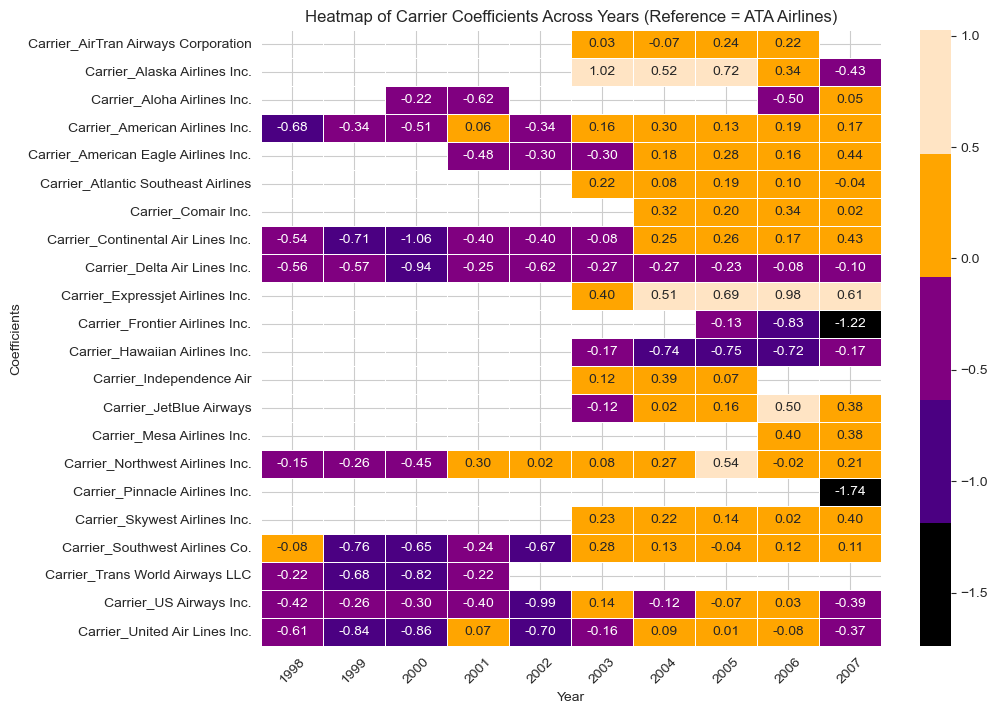

In [185]:
# Filter feature names to include only those containing "Carrier"
carrier_features = [feature for feature in coefficients_df['Feature'] if 'Carrier' in feature]

# Filter the coefficients dataframe to include only carrier-related features
carrier_coefficients_df = coefficients_df[coefficients_df['Feature'].isin(carrier_features)]

pivot_df = carrier_coefficients_df.pivot(index='Feature', columns='Year', values='Coefficient')

custom_palette = ["#000000", "#4B0082", "#800080", "#FFA500", "#FFE4C4"]

plt.figure(figsize=(10, 8))# Create a heatmap for carrier-related coefficients
heatmap = sns.heatmap(pivot_df,
                      cmap=custom_palette,  # Use custom palette
                      annot=True, fmt=".2f", linewidths=.5)
plt.title('Heatmap of Carrier Coefficients Across Years (Reference = ATA Airlines)')
plt.xlabel('Year')
plt.ylabel('Coefficients')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

Heatmap is also generated for "Month" variable to visualise coefficients across different year.

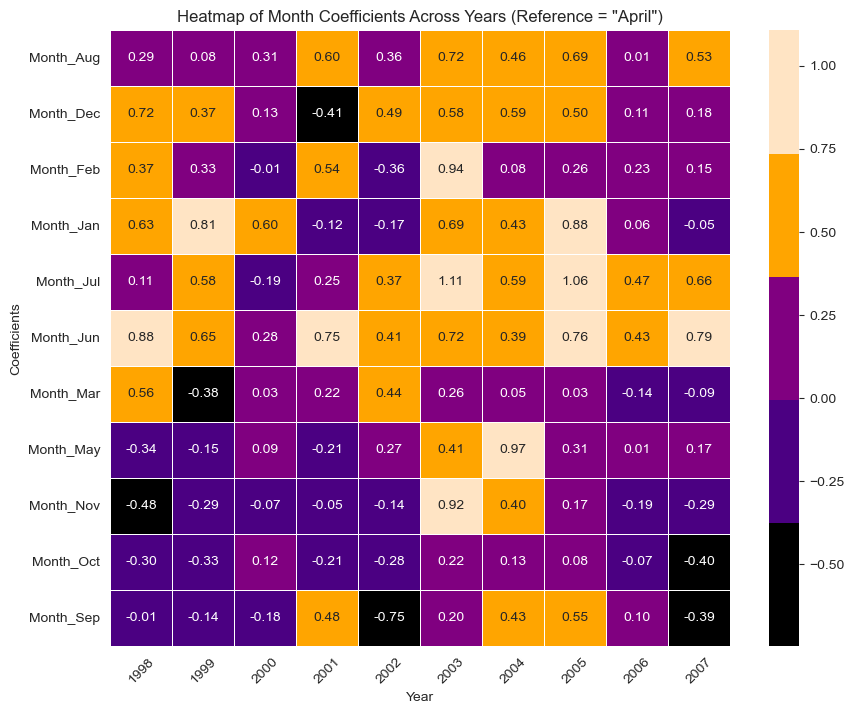

In [186]:
# Filter feature names to include only those containing "Carrier"
month_features = [feature for feature in coefficients_df['Feature'] if 'Month' in feature]
# Filter the coefficients dataframe to include only carrier-related features

carrier_coefficients_df = coefficients_df[coefficients_df['Feature'].isin(month_features)]
carrier_coefficients_df_sorted = carrier_coefficients_df.sort_values(by='Coefficient', ascending=False)

# Pivot the sorted DataFrame for the heatmap
pivot_df = carrier_coefficients_df_sorted.pivot(index='Feature', columns='Year', values='Coefficient')

custom_palette = ["#000000", "#4B0082", "#800080", "#FFA500", "#FFE4C4"]

plt.figure(figsize=(10, 8))# Create a heatmap for carrier-related coefficients
heatmap = sns.heatmap(pivot_df,
                      cmap=custom_palette,  # Use custom palette
                      annot=True, fmt=".2f", linewidths=.5)
plt.title('Heatmap of Month Coefficients Across Years (Reference = "April")')
plt.xlabel('Year')
plt.ylabel('Coefficients')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

We will create line charts to visualise the coefficients for "Distance", "long_Dest" and "long_Origin" across different year.

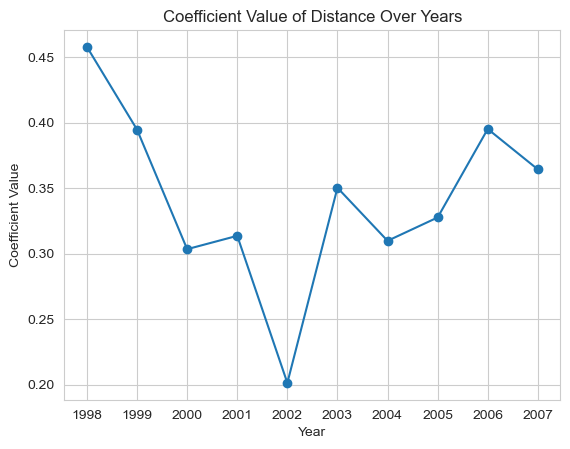

In [187]:
distance_coefficients_df = coefficients_df[coefficients_df['Feature'] == 'Distance']

plt.plot(distance_coefficients_df['Year'], distance_coefficients_df['Coefficient'], marker='o')
plt.title('Coefficient Value of Distance Over Years')
plt.xlabel('Year')
plt.ylabel('Coefficient Value')
plt.xticks(distance_coefficients_df['Year'])
plt.show()

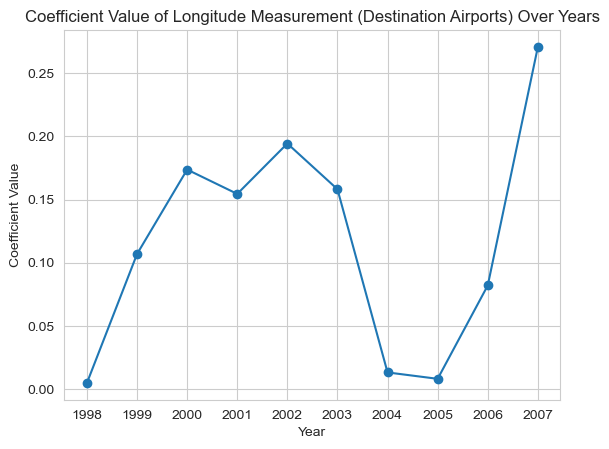

In [188]:
distance_coefficients_df = coefficients_df[coefficients_df['Feature'] == 'long_Dest']

plt.plot(distance_coefficients_df['Year'], distance_coefficients_df['Coefficient'], marker='o')
plt.title('Coefficient Value of Longitude Measurement (Destination Airports) Over Years')
plt.xlabel('Year')
plt.ylabel('Coefficient Value')
plt.xticks(distance_coefficients_df['Year'])
plt.show()

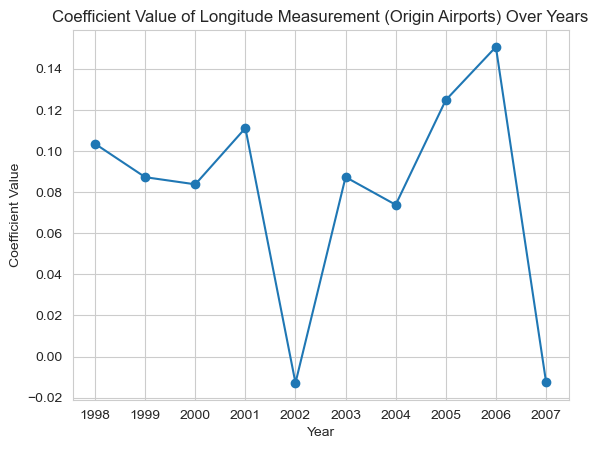

In [189]:
distance_coefficients_df = coefficients_df[coefficients_df['Feature'] == 'long_Origin']

plt.plot(distance_coefficients_df['Year'], distance_coefficients_df['Coefficient'], marker='o')
plt.title('Coefficient Value of Longitude Measurement (Origin Airports) Over Years')
plt.xlabel('Year')
plt.ylabel('Coefficient Value')
plt.xticks(distance_coefficients_df['Year'])
plt.show()